# Jet Clustering

## 1. Import Packages

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import uproot
import pyjet
import pandas as pd
import sys, os
import importlib
import time
import datetime

%config InlineBackend.figure_format = 'retina'  # increase figure showing resolution

## 2. Import .root Files

In [2]:
filepath_00_01 = '/youwei_home/SVJ_Quick/s-channel-v1/DelphesPythia8/svj_rinv00_run01.root'  # run01 stands for zeroth generation and Z'=100 GeV
filepath_00_02 = '/youwei_home/SVJ_Quick/s-channel-v1/DelphesPythia8/svj_rinv00_run02.root'  # run02 stands for zeroth generation and Z'=350 GeV
filepath_00_03 = '/youwei_home/SVJ_Quick/s-channel-v1/DelphesPythia8/svj_rinv00_run03.root'  # run03 stands for zeroth generation and Z'=750 GeV
filepath_00_04 = '/youwei_home/SVJ_Quick/s-channel-v1/DelphesPythia8/svj_rinv00_run04.root'  # run04 stands for zeroth generation and Z'=1500 GeV

filepath_03_01 = '/youwei_home/SVJ_Quick/s-channel-v1/DelphesPythia8/svj_rinv03_run01.root'
filepath_03_02 = '/youwei_home/SVJ_Quick/s-channel-v1/DelphesPythia8/svj_rinv03_run02.root'
filepath_03_03 = '/youwei_home/SVJ_Quick/s-channel-v1/DelphesPythia8/svj_rinv03_run03.root'
filepath_03_04 = '/youwei_home/SVJ_Quick/s-channel-v1/DelphesPythia8/svj_rinv03_run04.root'

filepath_07_01 = '/youwei_home/SVJ_Quick/s-channel-v1/DelphesPythia8/svj_rinv07_run01.root'
filepath_07_02 = '/youwei_home/SVJ_Quick/s-channel-v1/DelphesPythia8/svj_rinv07_run02.root'
filepath_07_03 = '/youwei_home/SVJ_Quick/s-channel-v1/DelphesPythia8/svj_rinv07_run03.root'
filepath_07_04 = '/youwei_home/SVJ_Quick/s-channel-v1/DelphesPythia8/svj_rinv07_run04.root'

file_00_01 = uproot.open(filepath_00_01)['Delphes;1']
file_00_02 = uproot.open(filepath_00_02)['Delphes;1']
file_00_03 = uproot.open(filepath_00_03)['Delphes;1']
file_00_04 = uproot.open(filepath_00_04)['Delphes;1']

file_03_01 = uproot.open(filepath_03_01)['Delphes;1']
file_03_02 = uproot.open(filepath_03_02)['Delphes;1']
file_03_03 = uproot.open(filepath_03_03)['Delphes;1']
file_03_04 = uproot.open(filepath_03_04)['Delphes;1']

file_07_01 = uproot.open(filepath_07_01)['Delphes;1']
file_07_02 = uproot.open(filepath_07_02)['Delphes;1']
file_07_03 = uproot.open(filepath_07_03)['Delphes;1']
file_07_04 = uproot.open(filepath_07_04)['Delphes;1']
file_03_04

<TTree b'Delphes' at 0x7fa02e3dd850>

## 3. Define the class to Fill Particle Informations into np.array

In [3]:
class BranchGenParticles:
    def __init__(self, data):
        self.data = data
        self.length = len(data.array('Particle.Status'))
        self.Status = data.array('Particle.Status')
        self.PID = data.array('Particle.PID')
        self.M1 = data.array('Particle.M1')
        self.M2 = data.array('Particle.M2')
        self.D1 = data.array('Particle.D1')
        self.D2 = data.array('Particle.D2')
        self.PT = data.array('Particle.PT')
        self.Eta = data.array('Particle.Eta')
        self.Phi = data.array('Particle.Phi')
        self.Mass = data.array('Particle.Mass')
        self.Labels = ['Status', 'PID', 'M1', 'M2', 'D1', 'D2', 'PT', 'Eta', 'Phi', 'Mass']
        
        
#     To get the GenParticles information array in the i-th event.
    def length_i(self, i):
        return len(self.Status[i])
    def Status_i(self, i):
        return self.Status[i]
    def PID_i(self, i):
        return self.PID[i]
    def M1_i(self, i):
        return self.M1[i]
    def M2_i(self, i):
        return self.M2[i]
    def D1_i(self, i):
        return self.D1[i]
    def D2_i(self, i):
        return self.D2[i]
    def PT_i(self, i):
        return self.PT[i]
    def Eta_i(self, i):
        return self.Eta[i]
    def Phi_i(self, i):
        return self.Phi[i]
    def Mass_i(self, i):
        return self.Mass[i]
    
    
    
class BranchJet:
    def __init__(self, data):
        self.data = data
        self.length = len(data.array('Jet.PT'))
        self.PT = data.array('Jet.PT')
        self.Eta = data.array('Jet.Eta')
        self.Phi = data.array('Jet.Phi')
        self.Mass = data.array('Jet.Mass')
        
    def length_i(self, i):
        return len(self.PT[i])
    def PT_i(self, i):
        return self.PT[i]
    def Eta_i(self, i):
        return self.Eta[i]
    def Phi_i(self, i):
        return self.Phi[i]
    def Mass_i(self, i):
        return self.Mass[i]
    
    
    
class Event_Weight:
    def __init__(self, data):
        self.data = data
        self.length = len(data.array('Event.Weight'))
        self.Event_Weight = np.array(data.array('Event.Weight'))
        
    def Event_Weight_i(self, i):
        return self.Event_Weight[i]

## 4. Define Functions

In [4]:
def M(pt1, eta1, phi1, m1, pt2, eta2, phi2, m2):
    px1, py1, pz1 = pt1*np.cos(phi1), pt1*np.sin(phi1), np.sqrt(m1**2+pt1**2)*np.sinh(eta1)
    e1 = np.sqrt(m1**2 + px1**2 + py1**2 + pz1**2)
    px2, py2, pz2 = pt2*np.cos(phi2), pt2*np.sin(phi2), np.sqrt(m2**2+pt2**2)*np.sinh(eta2)
    e2 = np.sqrt(m2**2 + px2**2 + py2**2 + pz2**2)
    return np.sqrt((e1+e2)**2 - (px1+px2)**2 - (py1+py2)**2 - (pz1+pz2)**2)



def MT(pt1, eta1, phi1, m1, pt2, eta2, phi2, m2):
    px1, py1, pz1 = pt1*np.cos(phi1), pt1*np.sin(phi1), np.sqrt(m1**2+pt1**2)*np.sinh(eta1)
    e1 = np.sqrt(m1**2 + px1**2 + py1**2 + pz1**2)
    px2, py2, pz2 = pt2*np.cos(phi2), pt2*np.sin(phi2), np.sqrt(m2**2+pt2**2)*np.sinh(eta2)
    e2 = np.sqrt(m2**2 + px2**2 + py2**2 + pz2**2)
    ET1, ET2 = np.sqrt(m1**2 + pt1**2), np.sqrt(m2**2 + pt2**2)
    return np.sqrt((ET1+ET2)**2 - (px1+px2)**2 - (py1+py2)**2)

In [5]:
def Find_xdxdbar(GP):
#     GP = GenParticles
    m_xdxdbar = []
    for i in range(GP.length):
        acc = 0
        for j in range(GP.length_i(i)):
            PID = GP.PID_i(i)[j]
            M1 = GP.M1_i(i)[j]
            M2 = GP.M2_i(i)[j]
            D1 = GP.D1_i(i)[j]
            D2 = GP.D2_i(i)[j]
            Status = GP.Status_i(i)[j]
            
            if PID == 5000001:
                if abs(GP.PID_i(i)[D1]) == abs(GP.PID_i(i)[D2]) == 4900101 and GP.Status_i(i)[D1] == GP.Status_i(i)[D2] == 23:
                    tmp_pt1 = GP.PT_i(i)[D1]
                    tmp_eta1 = GP.Eta_i(i)[D1]
                    tmp_phi1 = GP.Phi_i(i)[D1]
                    tmp_m1 = GP.Mass_i(i)[D1]
                    
                    tmp_pt2 = GP.PT_i(i)[D2]
                    tmp_eta2 = GP.Eta_i(i)[D2]
                    tmp_phi2 = GP.Phi_i(i)[D2]
                    tmp_m2 = GP.Mass_i(i)[D2]
                    break
            elif PID == 4900101 and Status == 23:
                tmp_pt1 = GP.PT_i(i)[j]
                tmp_eta1 = GP.Eta_i(i)[j]
                tmp_phi1 = GP.Phi_i(i)[j]
                tmp_m1 = GP.Mass_i(i)[j]
                acc += 1
                if acc == 2:
                    break
            elif PID == -4900101 and Status == 23:
                tmp_pt2 = GP.PT_i(i)[j]
                tmp_eta2 = GP.Eta_i(i)[j]
                tmp_phi2 = GP.Phi_i(i)[j]
                tmp_m2 = GP.Mass_i(i)[j]
                acc += 1
                if acc == 2:
                    break
                    
        m_xdxdbar.append(M(tmp_pt1, tmp_eta1, tmp_phi1, tmp_m1, tmp_pt2, tmp_eta2, tmp_phi2, tmp_m2))
            
    return np.array(m_xdxdbar)

In [117]:
def Preselection(Jet, pt=440):
    twojet_invariantmass = []
    survived_list = []
    for i in range(Jet.length):
        if Jet.length_i(i) < 2:
            continue
        elif Jet.PT_i(i)[0] < pt or Jet.PT_i(i)[1] < 60:
            continue
        elif np.abs(Jet.Eta_i(i)[0]-Jet.Eta_i(i)[1]) > 1.2:
            continue
            
        twojet_invariantmass.append(M(Jet.PT_i(i)[0], Jet.Eta_i(i)[0], Jet.Phi_i(i)[0], Jet.Mass_i(i)[0],
                                      Jet.PT_i(i)[1], Jet.Eta_i(i)[1], Jet.Phi_i(i)[1], Jet.Mass_i(i)[1]))
        survived_list.append(i)
        
    print('There are {} events.'.format(len(twojet_invariantmass)))
    return np.array(twojet_invariantmass), np.array(survived_list)

In [8]:
def StableFinalStateParticles(GP):
    event_SFSP = []
    for i in range(GP.length):
        event_SFSP_tmp = []
        for j in range(GP.length_i(i)):
            if GP.Status_i(i)[j] == 1:  # Stable Final State Particles
                event_SFSP_tmp.append([GP.PT_i(i)[j], GP.Eta_i(i)[j], GP.Phi_i(i)[j], GP.Mass_i(i)[j], GP.PID_i(i)[j]])
                
        event_SFSP.append(np.array(event_SFSP_tmp))
        
    return event_SFSP

In [123]:
def PreselectionMT(Jet, pt=440):
    twojet_invariantmass = []
    survived_list = []
    for i in range(Jet.length):
        if Jet.length_i(i) < 2:
            continue
        elif Jet.PT_i(i)[0] < pt or Jet.PT_i(i)[1] < 60:
            continue
        elif np.abs(Jet.Eta_i(i)[0]-Jet.Eta_i(i)[1]) > 1.2:
            continue
            
        twojet_invariantmass.append(MT(Jet.PT_i(i)[0], Jet.Eta_i(i)[0], Jet.Phi_i(i)[0], Jet.Mass_i(i)[0],
                                      Jet.PT_i(i)[1], Jet.Eta_i(i)[1], Jet.Phi_i(i)[1], Jet.Mass_i(i)[1]))
        survived_list.append(i)
        
    print('There are {} events.'.format(len(twojet_invariantmass)))
    return np.array(twojet_invariantmass), np.array(survived_list)

## 5. Load Event via class

In [9]:
GP_00_01, Jet_00_01, EW_00_01 = BranchGenParticles(file_00_01), BranchJet(file_00_01), Event_Weight(file_00_01)
GP_00_02, Jet_00_02, EW_00_02 = BranchGenParticles(file_00_02), BranchJet(file_00_02), Event_Weight(file_00_02)
GP_00_03, Jet_00_03, EW_00_03 = BranchGenParticles(file_00_03), BranchJet(file_00_03), Event_Weight(file_00_03)
GP_00_04, Jet_00_04, EW_00_04 = BranchGenParticles(file_00_04), BranchJet(file_00_04), Event_Weight(file_00_04)

GP_03_01, Jet_03_01, EW_03_01 = BranchGenParticles(file_03_01), BranchJet(file_03_01), Event_Weight(file_03_01)
GP_03_02, Jet_03_02, EW_03_02 = BranchGenParticles(file_03_02), BranchJet(file_03_02), Event_Weight(file_03_02)
GP_03_03, Jet_03_03, EW_03_03 = BranchGenParticles(file_03_03), BranchJet(file_03_03), Event_Weight(file_03_03)
GP_03_04, Jet_03_04, EW_03_04 = BranchGenParticles(file_03_04), BranchJet(file_03_04), Event_Weight(file_03_04)

GP_07_01, Jet_07_01, EW_07_01 = BranchGenParticles(file_07_01), BranchJet(file_07_01), Event_Weight(file_07_01)
GP_07_02, Jet_07_02, EW_07_02 = BranchGenParticles(file_07_02), BranchJet(file_07_02), Event_Weight(file_07_02)
GP_07_03, Jet_07_03, EW_07_03 = BranchGenParticles(file_07_03), BranchJet(file_07_03), Event_Weight(file_07_03)
GP_07_04, Jet_07_04, EW_07_04 = BranchGenParticles(file_07_04), BranchJet(file_07_04), Event_Weight(file_07_04)

## 6. Print The Truth Record in First Event for Status=1 with $r_\text{inv}=0.3$ & $M_{Z^\prime}=1500$ GeV

In [10]:
GP = GP_03_04
index = 0  # which event you want to print out

print('There are {} informations in this event.'.format(GP.length_i(index)))
print('{:^81}'.format('GenParticles Information'))
print('{:^5}{:^7}{:^8}{:^7}{:^7}{:^7}{:^7}{:^8}{:^8}{:^10}{:^8}'.format('#', 'Status', 'PID', 'M1', 'M2', 'D1', 'D2', 'PT', 'Eta', 'Phi', 'Mass'))
print('-'*81)

for j in range(GP.length_i(index)):
    if GP.Status_i(index)[j] == 1:  # Stable Final State Particles
        print('{:^5}{:^7d}{:^8d}{:^7d}{:^7d}{:^7d}{:^7d}{:^8.3f}{:^8.3f}{:^10.3f}{:^8.3f}'.format(j, GP.Status_i(index)[j], GP.PID_i(index)[j], GP.M1_i(index)[j],
                                                                           GP.M2_i(index)[j], GP.D1_i(index)[j], GP.D2_i(index)[j],
                                                                           GP.PT_i(index)[j], GP.Eta_i(index)[j], GP.Phi_i(index)[j], GP.Mass_i(index)[j]))

There are 1627 informations in this event.
                            GenParticles Information                             
  #  Status   PID     M1     M2     D1     D2      PT     Eta      Phi      Mass  
---------------------------------------------------------------------------------
 405    1     -211    401    402    -1     -1    0.772   6.333    -2.789   0.140  
 406    1     211     401    402    -1     -1    0.344   6.568    -0.302   0.140  
 407    1     2112    401    402    -1     -1    0.936   8.867    2.267    0.940  
 408    1     211     401    402    -1     -1    0.434   7.365    -1.993   0.140  
 417    1     211     409    415    -1     -1    0.210   6.628    -0.938   0.140  
 418    1     -211    409    415    -1     -1    0.398   7.243    2.394    0.140  
 419    1     321     409    415    -1     -1    0.275   6.390    2.067    0.494  
 422    1     -211    409    415    -1     -1    0.165   5.779    -0.150   0.140  
 428    1     -211    409    415    -1     -1 

## 7. Select Stable Final State Particles

In [11]:
print(time.strftime('%m/%d/%Y %a, %H:%M:%S %Z', time.localtime()))
start = datetime.datetime.now()

event_SFSP_03_02 = StableFinalStateParticles(GP_03_02)
print('There are {} events in this event list.'.format(len(event_SFSP_03_02)))
event_SFSP_03_04 = StableFinalStateParticles(GP_03_04)
print('There are {} events in this event list.'.format(len(event_SFSP_03_04)))
event_SFSP_07_02 = StableFinalStateParticles(GP_07_02)
print('There are {} events in this event list.'.format(len(event_SFSP_07_02)))
event_SFSP_07_04 = StableFinalStateParticles(GP_07_04)
print('There are {} events in this event list.'.format(len(event_SFSP_07_04)))

end = datetime.datetime.now()
print('Time =', end - start)

04/28/2021 Wed, 17:07:06 CST
There are 17850 events in this event list.
There are 14521 events in this event list.
There are 17805 events in this event list.
There are 14627 events in this event list.
Time = 0:30:16.302100


In [12]:
event_SFSP_03_04[0][1][0]

0.34375685453414917

In [13]:
GP = GP_03_04
index = 0  # which event you want to print out

print('There are {} informations in this event.'.format(GP.length_i(index)))
print('Print out first six informations of particle')
print('{:^81}'.format('GenParticles Information'))
print('{:^5}{:^7}{:^8}{:^7}{:^7}{:^7}{:^7}{:^8}{:^8}{:^10}{:^8}'.format('#', 'Status', 'PID', 'M1', 'M2', 'D1', 'D2', 'PT', 'Eta', 'Phi', 'Mass'))
print('-'*81)

for j in range(830):
    if GP.Status_i(index)[j] == 1:  # Stable Final State Particles
        print('{:^5}{:^7d}{:^8d}{:^7d}{:^7d}{:^7d}{:^7d}{:^8.3f}{:^8.3f}{:^10.3f}{:^8.3f}'.format(j, GP.Status_i(index)[j], GP.PID_i(index)[j], GP.M1_i(index)[j],
                                                                           GP.M2_i(index)[j], GP.D1_i(index)[j], GP.D2_i(index)[j],
                                                                           GP.PT_i(index)[j], GP.Eta_i(index)[j], GP.Phi_i(index)[j], GP.Mass_i(index)[j]))

There are 1627 informations in this event.
Print out first six informations of particle
                            GenParticles Information                             
  #  Status   PID     M1     M2     D1     D2      PT     Eta      Phi      Mass  
---------------------------------------------------------------------------------
 405    1     -211    401    402    -1     -1    0.772   6.333    -2.789   0.140  
 406    1     211     401    402    -1     -1    0.344   6.568    -0.302   0.140  
 407    1     2112    401    402    -1     -1    0.936   8.867    2.267    0.940  
 408    1     211     401    402    -1     -1    0.434   7.365    -1.993   0.140  
 417    1     211     409    415    -1     -1    0.210   6.628    -0.938   0.140  
 418    1     -211    409    415    -1     -1    0.398   7.243    2.394    0.140  
 419    1     321     409    415    -1     -1    0.275   6.390    2.067    0.494  
 422    1     -211    409    415    -1     -1    0.165   5.779    -0.150   0.140  
 

## 8. Let's Do Jet Clustering!!

In [113]:
event_jets_03_02 = []
for i in range(len(event_SFSP_03_02)):
    event_i = np.core.records.fromarrays(event_SFSP_03_02[i].transpose(),
                                         names='pT, eta, phi, mass, PID',
                                         formats='f8, f8, f8, f8, f8')
    pTmin = 100
    sequence_i = pyjet.cluster(event_i, R=0.6, p=-1)
    jets_i = sequence_i.inclusive_jets(pTmin)
    event_jets_03_02.append(jets_i)

In [16]:
event_jets_03_04 = []
for i in range(len(event_SFSP_03_04)):
    event_i = np.core.records.fromarrays(event_SFSP_03_04[i].transpose(),
                                         names='pT, eta, phi, mass, PID',
                                         formats='f8, f8, f8, f8, f8')
    pTmin = 200
    sequence_i = pyjet.cluster(event_i, R=0.6, p=-1)
    jets_i = sequence_i.inclusive_jets(pTmin)
    event_jets_03_04.append(jets_i)

In [56]:
event_jets_07_02 = []
for i in range(len(event_SFSP_07_02)):
    event_i = np.core.records.fromarrays(event_SFSP_07_02[i].transpose(),
                                         names='pT, eta, phi, mass, PID',
                                         formats='f8, f8, f8, f8, f8')
    pTmin = 100
    sequence_i = pyjet.cluster(event_i, R=0.6, p=-1)
    jets_i = sequence_i.inclusive_jets(pTmin)
    event_jets_07_02.append(jets_i)

In [18]:
event_jets_07_04 = []
for i in range(len(event_SFSP_07_04)):
    event_i = np.core.records.fromarrays(event_SFSP_07_04[i].transpose(),
                                         names='pT, eta, phi, mass, PID',
                                         formats='f8, f8, f8, f8, f8')
    pTmin = 200
    sequence_i = pyjet.cluster(event_i, R=0.6, p=-1)
    jets_i = sequence_i.inclusive_jets(pTmin)
    event_jets_07_04.append(jets_i)

In [ ]:
event_SFSP_03_02
event_SFSP_03_04
event_SFSP_07_02
event_SFSP_07_04

In [19]:
event_jets_03_04[0]

[PseudoJet(pt=381.869, eta=1.043, phi=-0.904, mass=79.611),
 PseudoJet(pt=306.688, eta=-0.616, phi=1.888, mass=65.503)]

## 9. Print Jets in the ith(first) Event

In [20]:
# Printing a few things here as a demonstration of the basic functionality
ith = 0

print('Information of {}th Event'.format(ith+1))
print('{0: <5} {1: >10} {2: >10} {3: >10} {4: >10} {5: >10}'.format('jet#', 'pT', 'eta', 'phi', 'mass', '#constit.'))
for i, jet in enumerate(event_jets_03_04[ith]):
    print('{0: <5} {1: 10.3f} {2: 10.3f} {3: 10.3f} {4: 10.3f} {5: 10}'.format(i+1, jet.pt, jet.eta, jet.phi, jet.mass, len(jet)))
    
print('\nThe 2th jet has {} particles in 2nd PseudoJet.'.format(len(event_jets_03_04[ith][1])))
print('\nThe 2th jet has the following constituents:')
for constit in event_jets_03_04[ith][1]:
    print(constit)
print('\nGet the constituents as an array (pT, eta, phi, mass):')
print(event_jets_03_04[ith][1].constituents_array())
print('\nor (E, px, py, pz):')
print(event_jets_03_04[ith][1].constituents_array(ep=True))

Information of 1th Event
jet#          pT        eta        phi       mass  #constit.
1        381.869      1.043     -0.904     79.611         57
2        306.688     -0.616      1.888     65.503         57

The 2th jet has 57 particles in 2nd PseudoJet.

The 2th jet has the following constituents:
PseudoJet(pt=2.772, eta=-0.526, phi=2.472, mass=0.494)
PseudoJet(pt=1.704, eta=-0.323, phi=2.383, mass=0.000)
PseudoJet(pt=2.983, eta=-0.184, phi=2.262, mass=0.940)
PseudoJet(pt=2.024, eta=-1.175, phi=1.969, mass=0.000)
PseudoJet(pt=0.334, eta=-0.267, phi=2.312, mass=0.140)
PseudoJet(pt=0.735, eta=-1.074, phi=1.540, mass=0.140)
PseudoJet(pt=0.242, eta=-0.286, phi=2.340, mass=0.000)
PseudoJet(pt=6.188, eta=-0.197, phi=2.205, mass=0.940)
PseudoJet(pt=0.529, eta=-0.186, phi=2.184, mass=0.000)
PseudoJet(pt=0.615, eta=-0.213, phi=2.136, mass=0.498)
PseudoJet(pt=6.824, eta=-0.248, phi=2.219, mass=0.140)
PseudoJet(pt=0.398, eta=-0.463, phi=1.375, mass=0.140)
PseudoJet(pt=2.376, eta=-0.679, phi=2.3

## 10. Find the Xd(4900101) and Xd~(-4900101) in the Truth Record Table for Invariant Mass

In [21]:
print(time.strftime('%m/%d/%Y %a, %H:%M:%S %Z', time.localtime()))
start = datetime.datetime.now()

m_xdxdbar_03_02 = Find_xdxdbar(GP_03_02)
m_xdxdbar_03_04 = Find_xdxdbar(GP_03_04)
m_xdxdbar_07_02 = Find_xdxdbar(GP_07_02)
m_xdxdbar_07_04 = Find_xdxdbar(GP_07_04)

end = datetime.datetime.now()
print('Time =', end - start)

04/28/2021 Wed, 17:55:31 CST
Time = 0:18:38.155684


## 11. Calculate di-jet Invariant Mass from Detector Simulation

In [121]:
dijet_mass_03_02, survived_list_03_02 = Preselection(Jet_03_02, pt=110)
dijet_mass_03_04, survived_list_03_04 = Preselection(Jet_03_04)
dijet_mass_07_02, survived_list_07_02 = Preselection(Jet_07_02, pt=110)
dijet_mass_07_04, survived_list_07_04 = Preselection(Jet_07_04)

There are 4748 events.
There are 5147 events.
There are 2554 events.
There are 2831 events.


In [124]:
dijet_massT_03_02, survived_list_03_02_MT = PreselectionMT(Jet_03_02, pt=110)
dijet_massT_03_04, survived_list_03_04_MT = PreselectionMT(Jet_03_04)
dijet_massT_07_02, survived_list_07_02_MT = PreselectionMT(Jet_07_02, pt=110)
dijet_massT_07_04, survived_list_07_04_MT = PreselectionMT(Jet_07_04)

There are 4748 events.
There are 5147 events.
There are 2554 events.
There are 2831 events.


In [89]:
dijet_mass_03_04

array([1024.82895426,  760.1945258 , 1177.25819103, ...,  744.06142781,
        614.68161856,  948.04590292])

In [90]:
dijet_massT_03_04

array([ 984.77928911,  691.95312212, 1062.8434639 , ...,  705.07182716,
        588.70957494,  845.41038396])

## 12. Calculate the Number of Event for Event Weight

In [23]:
weight_03_02 = EW_03_02.Event_Weight/20000
weight_03_04 = EW_03_04.Event_Weight/20000
weight_07_02 = EW_07_02.Event_Weight/20000
weight_07_04 = EW_07_04.Event_Weight/20000

## 13. di-jet Events' Selection from Truth Record

In [114]:
M_JJ_03_02 = []
event_sele_03_02 = []

for i in range(len(event_jets_03_02)):
    if len(event_jets_03_02[i]) >= 2:  # at least two jets in this event.
        jet_1 = event_jets_03_02[i][0]  # leading jet's information
        jet_2 = event_jets_03_02[i][1]  # subleading jet's information
        
        M_JJ_03_02.append(M(jet_1.pt, jet_1.eta, jet_1.phi, jet_1.mass, jet_2.pt, jet_2.eta, jet_2.phi, jet_2.mass))
        event_sele_03_02.append(i)
        
print('There are {} events passed this di-jet selection.'.format(len(M_JJ_03_02)))

There are 8066 events passed this di-jet selection.


In [25]:
M_JJ_03_04 = []
event_sele_03_04 = []

for i in range(len(event_jets_03_04)):
    if len(event_jets_03_04[i]) >= 2:  # at least two jets in this event.
        jet_1 = event_jets_03_04[i][0]  # leading jet's information
        jet_2 = event_jets_03_04[i][1]  # subleading jet's information
        
        M_JJ_03_04.append(M(jet_1.pt, jet_1.eta, jet_1.phi, jet_1.mass, jet_2.pt, jet_2.eta, jet_2.phi, jet_2.mass))
        event_sele_03_04.append(i)
        
print('There are {} events passed this di-jet selection.'.format(len(M_JJ_03_04)))

There are 12683 events passed this di-jet selection.


In [58]:
M_JJ_07_02 = []
event_sele_07_02 = []

for i in range(len(event_jets_07_02)):
    if len(event_jets_07_02[i]) >= 2:  # at least two jets in this event.
        jet_1 = event_jets_07_02[i][0]  # leading jet's information
        jet_2 = event_jets_07_02[i][1]  # subleading jet's information
        
        M_JJ_07_02.append(M(jet_1.pt, jet_1.eta, jet_1.phi, jet_1.mass, jet_2.pt, jet_2.eta, jet_2.phi, jet_2.mass))
        event_sele_07_02.append(i)
        
print('There are {} events passed this di-jet selection.'.format(len(M_JJ_07_02)))

There are 8569 events passed this di-jet selection.


In [27]:
M_JJ_07_04 = []
event_sele_07_04 = []

for i in range(len(event_jets_07_04)):
    if len(event_jets_07_04[i]) >= 2:  # at least two jets in this event.
        jet_1 = event_jets_07_04[i][0]  # leading jet's information
        jet_2 = event_jets_07_04[i][1]  # subleading jet's information
        
        M_JJ_07_04.append(M(jet_1.pt, jet_1.eta, jet_1.phi, jet_1.mass, jet_2.pt, jet_2.eta, jet_2.phi, jet_2.mass))
        event_sele_07_04.append(i)
        
print('There are {} events passed this di-jet selection.'.format(len(M_JJ_07_04)))

There are 12837 events passed this di-jet selection.


## 14. Plot

### 14-1. Example 2: Plot in normalized to one with $r_\text{inv}=0.3$ & $M_{Z^\prime}=1500$ GeV

Total events = 14521


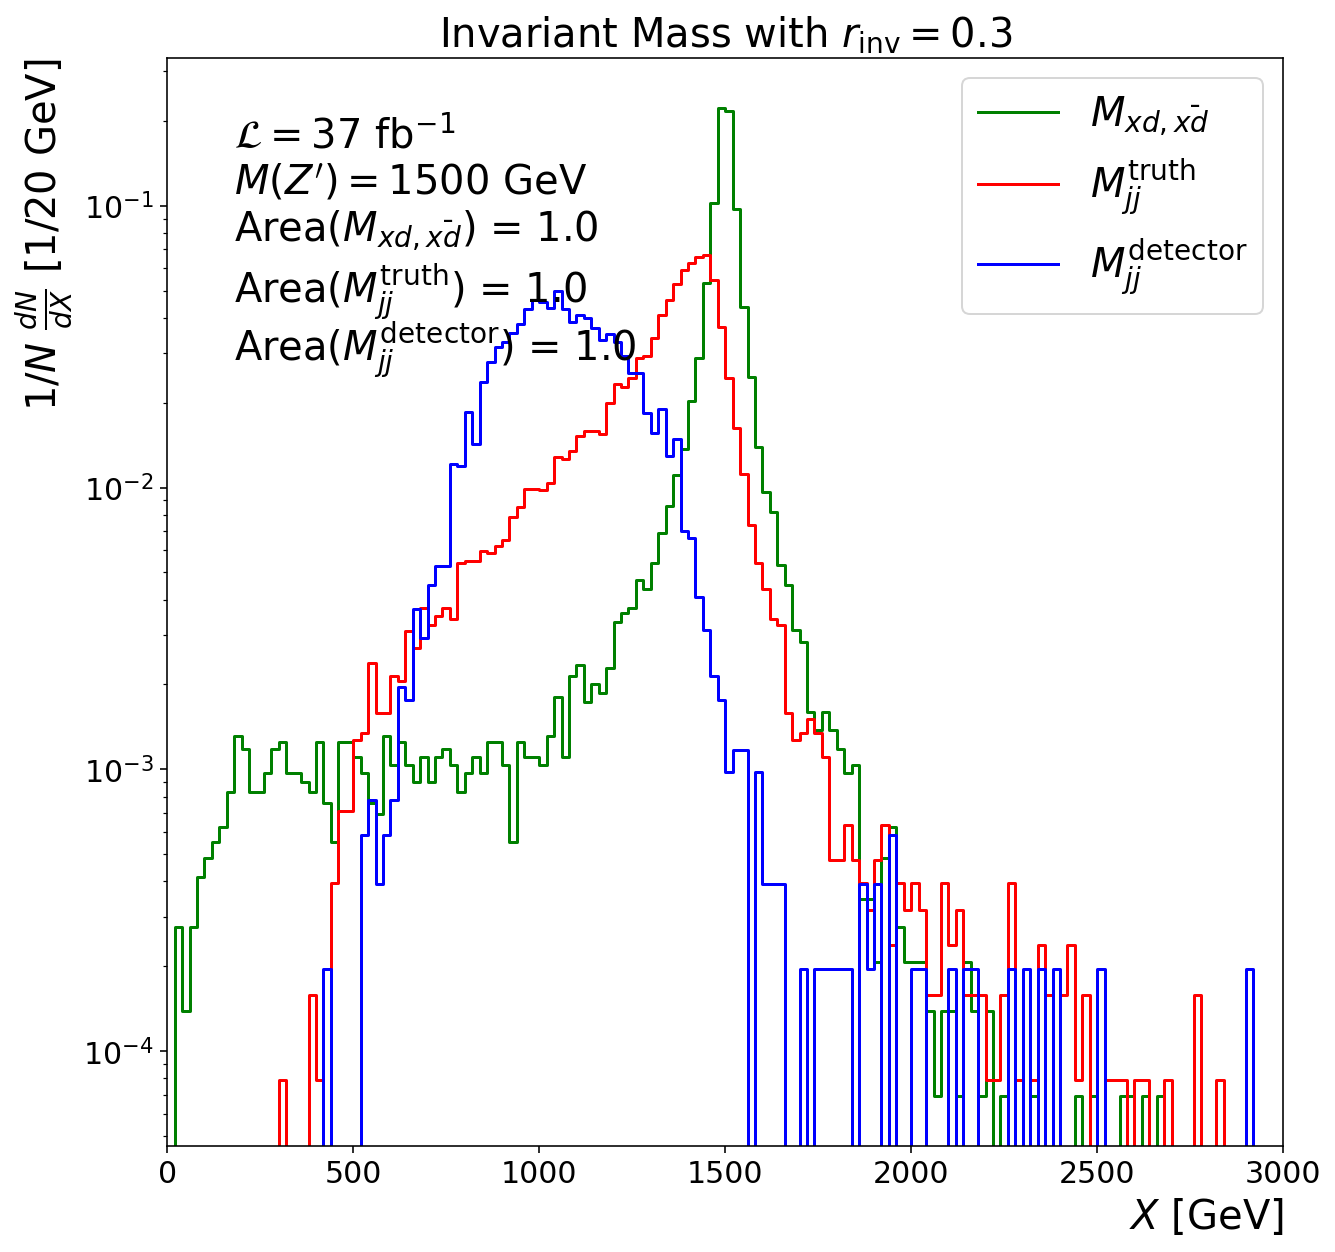

In [101]:
plt.figure(figsize=(10,10))  # plot size
print('Total events = {}'.format(len(m_xdxdbar_03_04)))

bin_size = np.linspace(0,5000,251)
hist, bins = np.histogram(m_xdxdbar_03_04, bins=bin_size, weights=weight_03_04)
plt.step(bins[:-1], hist/np.sum(hist), where='post', color='green', label='$M_{xd,\\bar{xd}}$')
# plt.step(bins[:-1], hist.astype(np.float32), where='post', color='green', label='$M_{xd,\\bar{xd}}$')

hist_M_JJ, bins_M_JJ = np.histogram(M_JJ_03_04, bins=bin_size, weights=weight_03_04[event_sele_03_04]*37*1000)
plt.step(bins_M_JJ[:-1], hist_M_JJ/np.sum(hist_M_JJ), where='post', color='red', label='$M^\mathrm{truth}_{jj}$')

hist_M_JJ_detec, bins_M_JJ_detec = np.histogram(dijet_mass_03_04, bins=bin_size, weights=weight_03_04[survived_list_03_04]*37*1000)
plt.step(bins_M_JJ_detec[:-1], hist_M_JJ_detec/np.sum(hist_M_JJ_detec), where='post', color='blue', label='$M^\mathrm{detector}_{jj}$')



plt.text(180, 0.16, '$\mathcal{L} = 37\ \mathrm{fb}^{-1}$', fontsize=20)
plt.text(180, 0.11, '$M(Z^\prime) = 1500$ GeV', fontsize=20)
plt.text(180, 0.075, 'Area($M_{xd,\\bar{xd}}$) = '+str(np.round(np.sum(hist.astype(np.float32)/np.sum(hist)),2)), fontsize=20)
plt.text(180, 0.045, 'Area($M^\mathrm{truth}_{jj}$) = '+str(np.round(np.sum(hist_M_JJ)/np.sum(hist_M_JJ),2)[0]), fontsize=20)
plt.text(180, 0.028, 'Area($M^\mathrm{detector}_{jj}$) = '+str(np.round(np.sum(hist_M_JJ_detec)/np.sum(hist_M_JJ_detec),2)[0]), fontsize=20)



plt.legend(fontsize=20)
plt.yscale('log')
plt.title('Invariant Mass with $r_\mathrm{inv}=0.3$', fontsize=20)
plt.xlabel('$X$ [GeV]', fontsize=20, horizontalalignment='right', x=1)
plt.ylabel('$1/N\ \\frac{dN}{dX}$ [1/20 GeV]', fontsize=20, horizontalalignment='right', y=1)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim(0,3000)
# plt.ylim(0.001,0.1)
plt.show()

### 14-2: Example 2: Plot in normalized to one with $r_\text{inv}=0.7$ & $M_{Z^\prime}=1500$ GeV

Total events = 14627


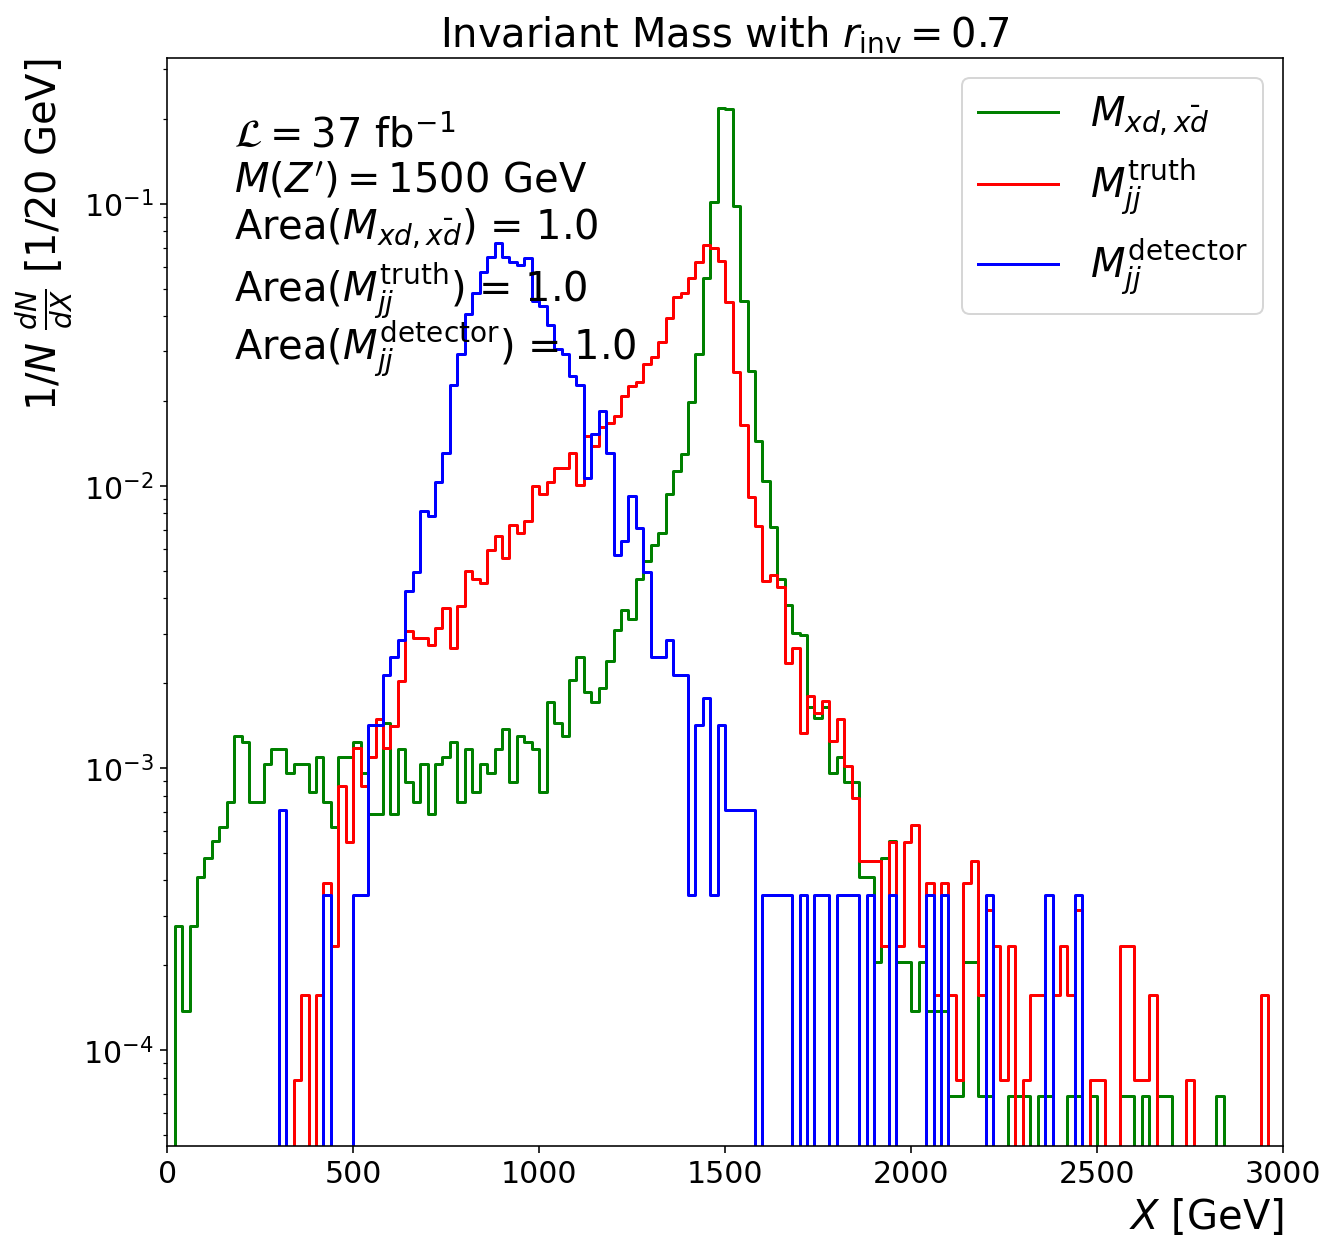

In [102]:
plt.figure(figsize=(10,10))  # plot size
print('Total events = {}'.format(len(m_xdxdbar_07_04)))

bin_size = np.linspace(0,5000,251)
hist, bins = np.histogram(m_xdxdbar_07_04, bins=bin_size, weights=weight_07_04)
plt.step(bins[:-1], hist/np.sum(hist), where='post', color='green', label='$M_{xd,\\bar{xd}}$')
# plt.step(bins[:-1], hist.astype(np.float32), where='post', color='green', label='$M_{xd,\\bar{xd}}$')

hist_M_JJ, bins_M_JJ = np.histogram(M_JJ_07_04, bins=bin_size, weights=weight_07_04[event_sele_07_04]*37*1000)
plt.step(bins_M_JJ[:-1], hist_M_JJ/np.sum(hist_M_JJ), where='post', color='red', label='$M^\mathrm{truth}_{jj}$')

hist_M_JJ_detec, bins_M_JJ_detec = np.histogram(dijet_mass_07_04, bins=bin_size, weights=weight_07_04[survived_list_07_04]*37*1000)
plt.step(bins_M_JJ_detec[:-1], hist_M_JJ_detec/np.sum(hist_M_JJ_detec), where='post', color='blue', label='$M^\mathrm{detector}_{jj}$')



plt.text(180, 0.16, '$\mathcal{L} = 37\ \mathrm{fb}^{-1}$', fontsize=20)
plt.text(180, 0.11, '$M(Z^\prime) = 1500$ GeV', fontsize=20)
plt.text(180, 0.075, 'Area($M_{xd,\\bar{xd}}$) = '+str(np.round(np.sum(hist.astype(np.float32)/np.sum(hist)),2)), fontsize=20)
plt.text(180, 0.045, 'Area($M^\mathrm{truth}_{jj}$) = '+str(np.round(np.sum(hist_M_JJ)/np.sum(hist_M_JJ),2)[0]), fontsize=20)
plt.text(180, 0.028, 'Area($M^\mathrm{detector}_{jj}$) = '+str(np.round(np.sum(hist_M_JJ_detec)/np.sum(hist_M_JJ_detec),2)[0]), fontsize=20)



plt.legend(fontsize=20)
plt.yscale('log')
plt.title('Invariant Mass with $r_\mathrm{inv}=0.7$', fontsize=20)
plt.xlabel('$X$ [GeV]', fontsize=20, horizontalalignment='right', x=1)
plt.ylabel('$1/N\ \\frac{dN}{dX}$ [1/20 GeV]', fontsize=20, horizontalalignment='right', y=1)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim(0,3000)
# plt.ylim(0.001,0.1)
plt.show()

### 14-3. Example 2: Plot in normalized to one with $r_\text{inv}=0.3$ & $M_{Z^\prime}=350$ GeV

Total events = 17850


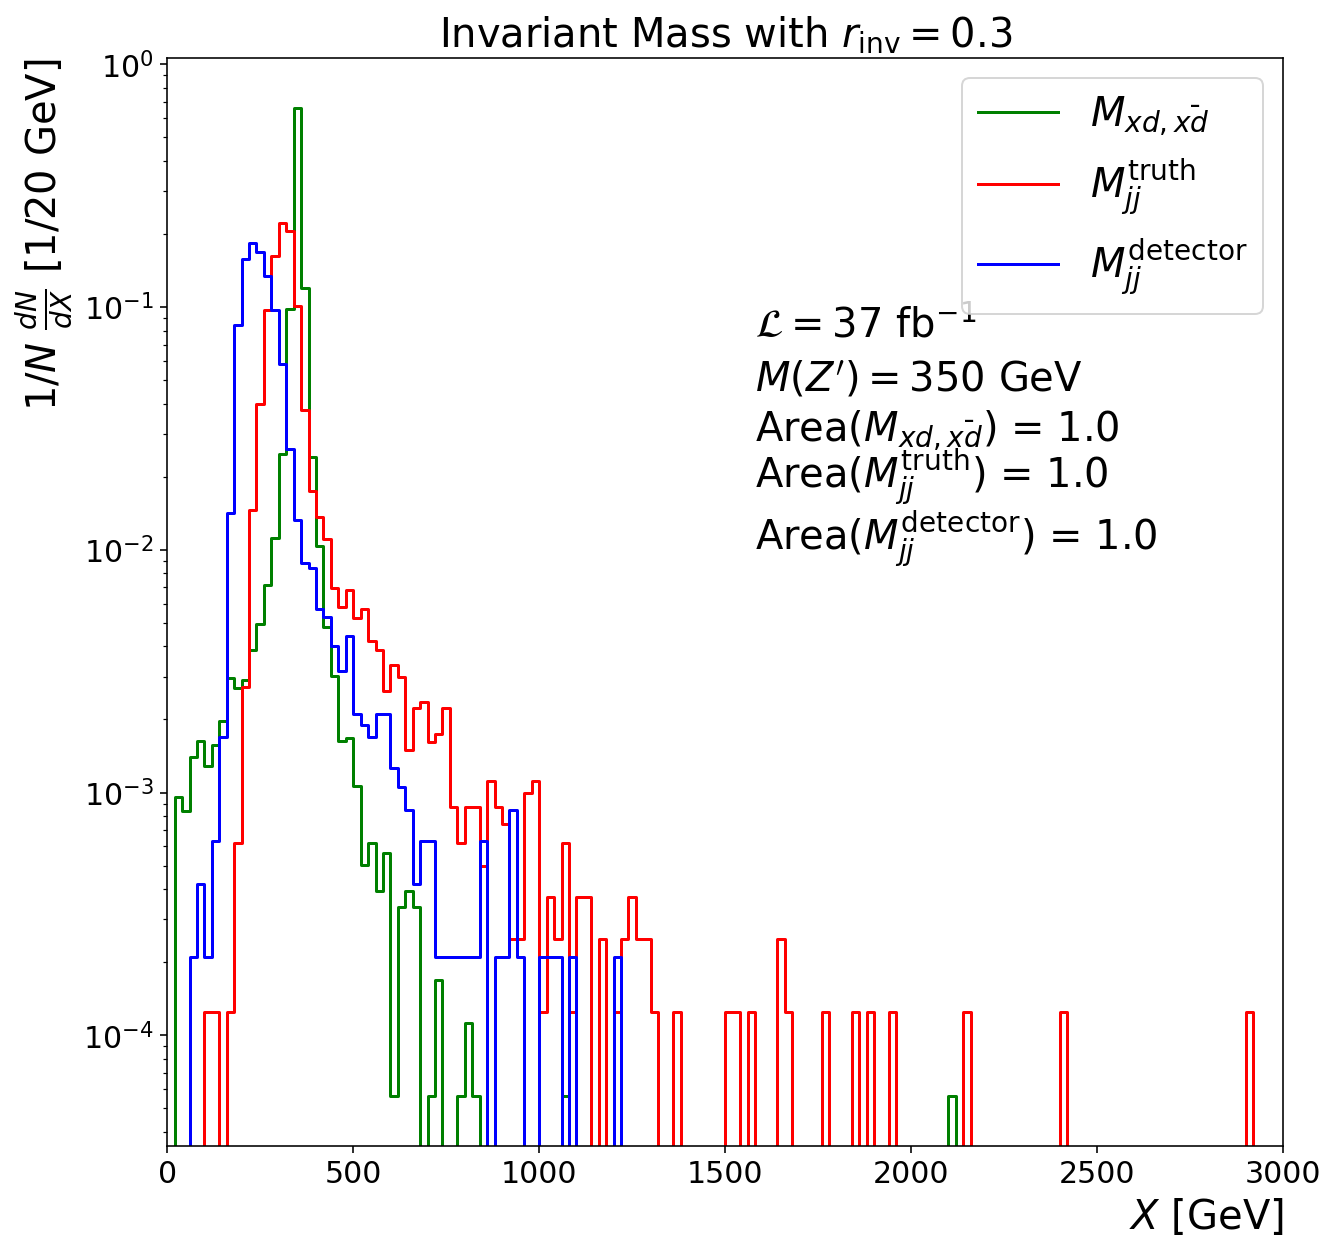

In [127]:
plt.figure(figsize=(10,10))  # plot size
print('Total events = {}'.format(len(m_xdxdbar_03_02)))

bin_size = np.linspace(0,5000,251)
hist, bins = np.histogram(m_xdxdbar_03_02, bins=bin_size, weights=weight_03_02)
plt.step(bins[:-1], hist/np.sum(hist), where='post', color='green', label='$M_{xd,\\bar{xd}}$')
# plt.step(bins[:-1], hist.astype(np.float32), where='post', color='green', label='$M_{xd,\\bar{xd}}$')

hist_M_JJ, bins_M_JJ = np.histogram(M_JJ_03_02, bins=bin_size, weights=weight_03_02[event_sele_03_02]*37*1000)
plt.step(bins_M_JJ[:-1], hist_M_JJ/np.sum(hist_M_JJ), where='post', color='red', label='$M^\mathrm{truth}_{jj}$')

hist_M_JJ_detec, bins_M_JJ_detec = np.histogram(dijet_mass_03_02, bins=bin_size, weights=weight_03_02[survived_list_03_02]*37*1000)
plt.step(bins_M_JJ_detec[:-1], hist_M_JJ_detec/np.sum(hist_M_JJ_detec), where='post', color='blue', label='$M^\mathrm{detector}_{jj}$')



plt.text(1580, 0.075, '$\mathcal{L} = 37\ \mathrm{fb}^{-1}$', fontsize=20)
plt.text(1580, 0.045, '$M(Z^\prime) = 350$ GeV', fontsize=20)
plt.text(1580, 0.028, 'Area($M_{xd,\\bar{xd}}$) = '+str(np.round(np.sum(hist.astype(np.float32)/np.sum(hist)),2)), fontsize=20)
plt.text(1580, 0.018, 'Area($M^\mathrm{truth}_{jj}$) = '+str(np.round(np.sum(hist_M_JJ)/np.sum(hist_M_JJ),2)[0]), fontsize=20)
plt.text(1580, 0.01, 'Area($M^\mathrm{detector}_{jj}$) = '+str(np.round(np.sum(hist_M_JJ_detec)/np.sum(hist_M_JJ_detec),2)[0]), fontsize=20)



plt.legend(fontsize=20)
plt.yscale('log')
plt.title('Invariant Mass with $r_\mathrm{inv}=0.3$', fontsize=20)
plt.xlabel('$X$ [GeV]', fontsize=20, horizontalalignment='right', x=1)
plt.ylabel('$1/N\ \\frac{dN}{dX}$ [1/20 GeV]', fontsize=20, horizontalalignment='right', y=1)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim(0,3000)
# plt.ylim(0.001,0.1)
plt.show()

### 14-4. Example 2: Plot in normalized to one with $r_\text{inv}=0.7$ & $M_{Z^\prime}=350$ GeV

Total events = 17805


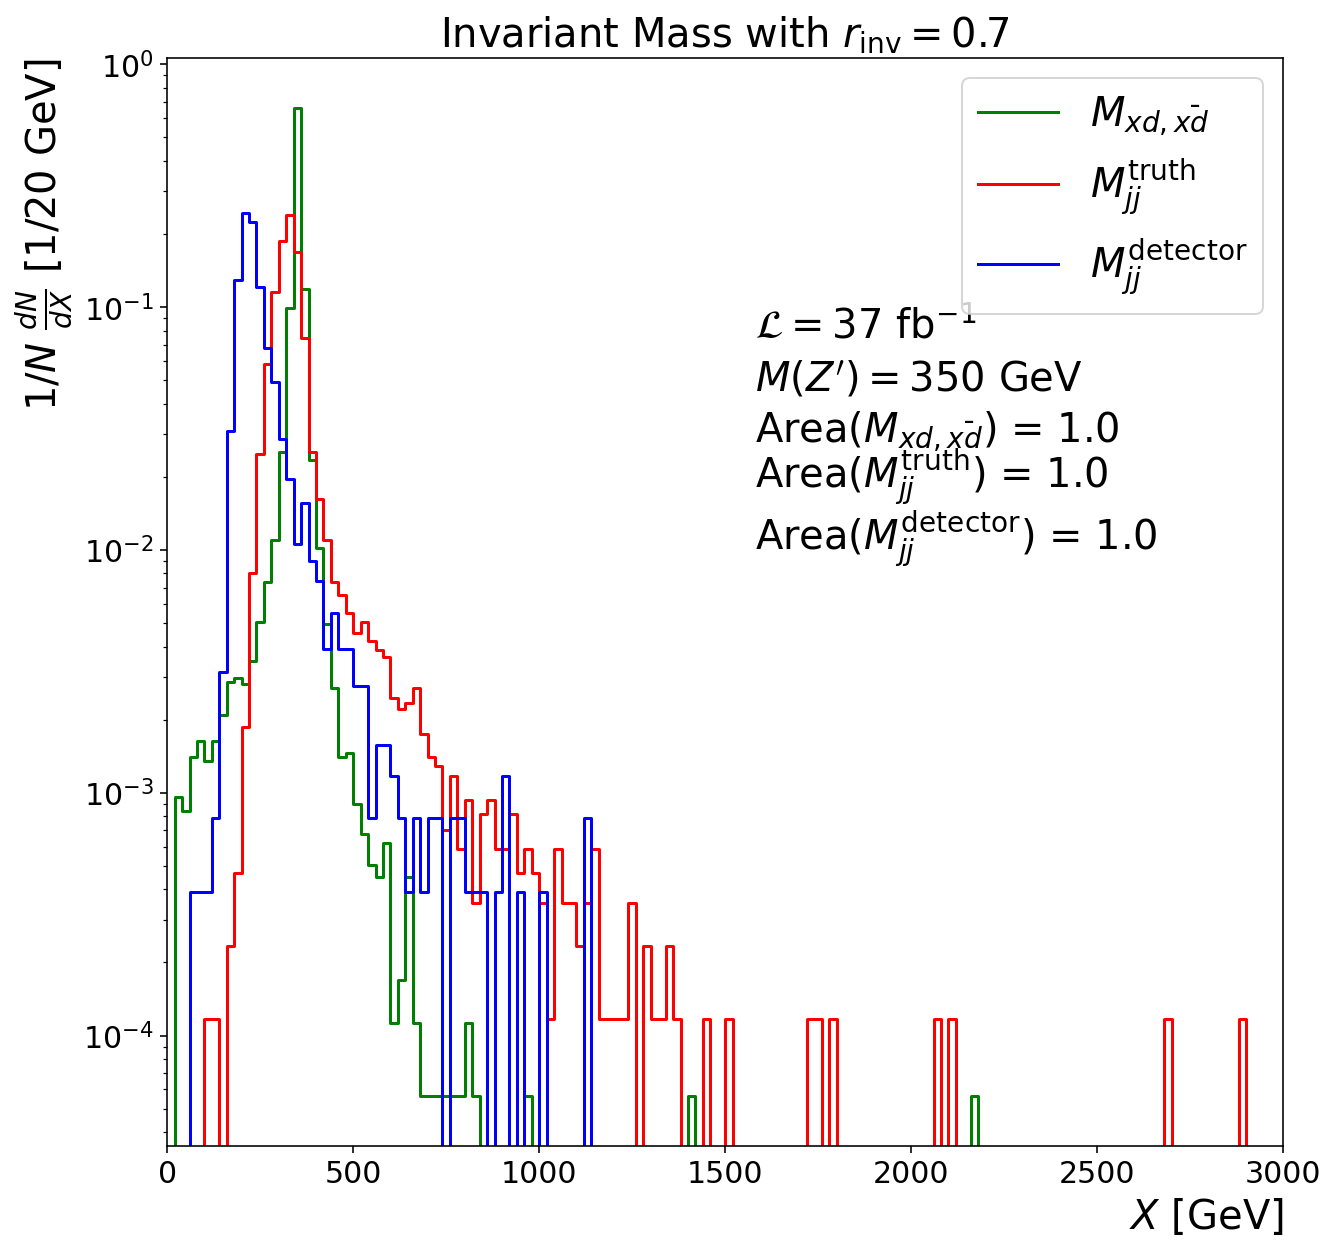

In [147]:
plt.figure(figsize=(10,10))  # plot size
print('Total events = {}'.format(len(m_xdxdbar_07_02)))

bin_size = np.linspace(0,5000,251)
hist, bins = np.histogram(m_xdxdbar_07_02, bins=bin_size, weights=weight_07_02)
plt.step(bins[:-1], hist/np.sum(hist), where='post', color='green', label='$M_{xd,\\bar{xd}}$')
# plt.step(bins[:-1], hist.astype(np.float32), where='post', color='green', label='$M_{xd,\\bar{xd}}$')

hist_M_JJ, bins_M_JJ = np.histogram(M_JJ_07_02, bins=bin_size, weights=weight_07_02[event_sele_07_02]*37*1000)
plt.step(bins_M_JJ[:-1], hist_M_JJ/np.sum(hist_M_JJ), where='post', color='red', label='$M^\mathrm{truth}_{jj}$')

hist_M_JJ_detec, bins_M_JJ_detec = np.histogram(dijet_mass_07_02, bins=bin_size, weights=weight_07_02[survived_list_07_02]*37*1000)
plt.step(bins_M_JJ_detec[:-1], hist_M_JJ_detec/np.sum(hist_M_JJ_detec), where='post', color='blue', label='$M^\mathrm{detector}_{jj}$')



plt.text(1580, 0.075, '$\mathcal{L} = 37\ \mathrm{fb}^{-1}$', fontsize=20)
plt.text(1580, 0.045, '$M(Z^\prime) = 350$ GeV', fontsize=20)
plt.text(1580, 0.028, 'Area($M_{xd,\\bar{xd}}$) = '+str(np.round(np.sum(hist.astype(np.float32)/np.sum(hist)),2)), fontsize=20)
plt.text(1580, 0.018, 'Area($M^\mathrm{truth}_{jj}$) = '+str(np.round(np.sum(hist_M_JJ)/np.sum(hist_M_JJ),2)[0]), fontsize=20)
plt.text(1580, 0.01, 'Area($M^\mathrm{detector}_{jj}$) = '+str(np.round(np.sum(hist_M_JJ_detec)/np.sum(hist_M_JJ_detec),2)[0]), fontsize=20)



plt.legend(fontsize=20)
plt.yscale('log')
plt.title('Invariant Mass with $r_\mathrm{inv}=0.7$', fontsize=20)
plt.xlabel('$X$ [GeV]', fontsize=20, horizontalalignment='right', x=1)
plt.ylabel('$1/N\ \\frac{dN}{dX}$ [1/20 GeV]', fontsize=20, horizontalalignment='right', y=1)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim(0,3000)
# plt.ylim(0.001,0.1)
plt.show()

### 14-5. $M_{jj}^\text{truth}$

Total events = 17850
Total events = 14521
Total events = 17805
Total events = 14627


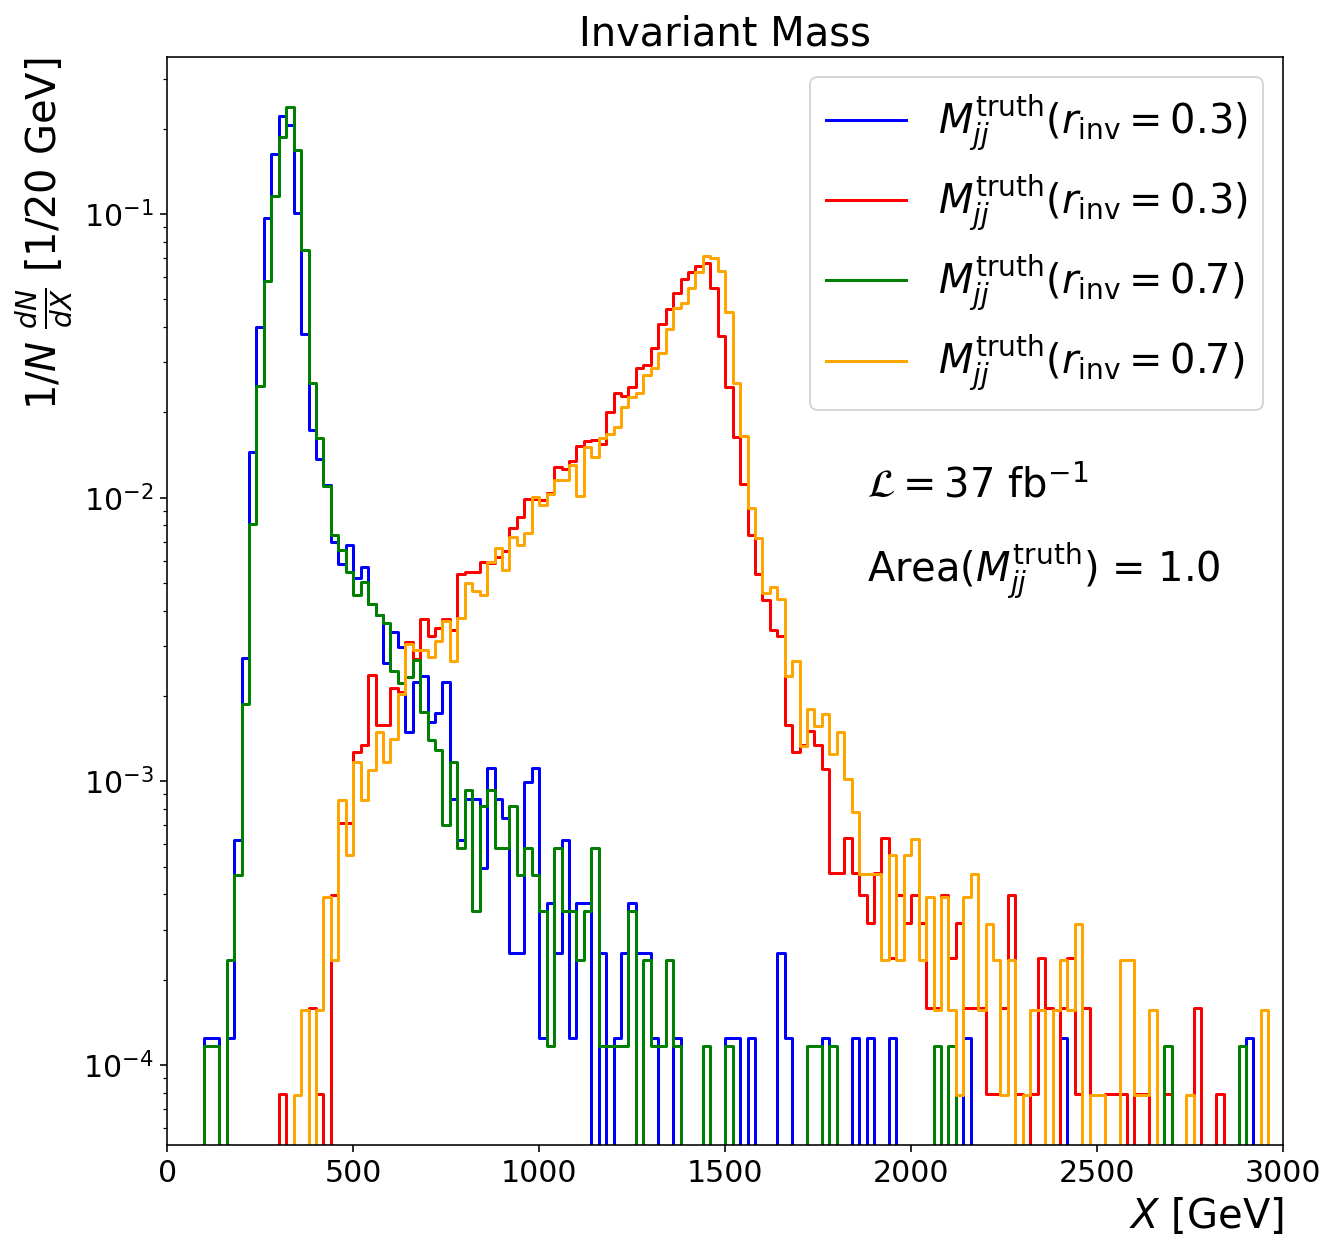

In [148]:
plt.figure(figsize=(10,10))  # plot size
print('Total events = {}'.format(len(m_xdxdbar_03_02)))
print('Total events = {}'.format(len(m_xdxdbar_03_04)))
print('Total events = {}'.format(len(m_xdxdbar_07_02)))
print('Total events = {}'.format(len(m_xdxdbar_07_04)))

bin_size = np.linspace(0,5000,251)
hist_M_JJ, bins_M_JJ = np.histogram(M_JJ_03_02, bins=bin_size, weights=weight_03_02[event_sele_03_02]*37*1000)
plt.step(bins_M_JJ[:-1], hist_M_JJ/np.sum(hist_M_JJ), where='post', color='blue', label='$M^\mathrm{truth}_{jj}(r_\mathrm{inv}=0.3)$')

hist_M_JJ, bins_M_JJ = np.histogram(M_JJ_03_04, bins=bin_size, weights=weight_03_04[event_sele_03_04]*37*1000)
plt.step(bins_M_JJ[:-1], hist_M_JJ/np.sum(hist_M_JJ), where='post', color='red', label='$M^\mathrm{truth}_{jj}(r_\mathrm{inv}=0.3)$')

hist_M_JJ, bins_M_JJ = np.histogram(M_JJ_07_02, bins=bin_size, weights=weight_07_02[event_sele_07_02]*37*1000)
plt.step(bins_M_JJ[:-1], hist_M_JJ/np.sum(hist_M_JJ), where='post', color='green', label='$M^\mathrm{truth}_{jj}(r_\mathrm{inv}=0.7)$')

hist_M_JJ, bins_M_JJ = np.histogram(M_JJ_07_04, bins=bin_size, weights=weight_07_04[event_sele_07_04]*37*1000)
plt.step(bins_M_JJ[:-1], hist_M_JJ/np.sum(hist_M_JJ), where='post', color='orange', label='$M^\mathrm{truth}_{jj}(r_\mathrm{inv}=0.7)$')



plt.text(1880, 0.01, '$\mathcal{L} = 37\ \mathrm{fb}^{-1}$', fontsize=20)
#plt.text(180, 0.11, '$M(Z^\prime) = 1500$ GeV', fontsize=20)
#plt.text(180, 0.075, 'Area($M_{xd,\\bar{xd}}$) = '+str(np.round(np.sum(hist.astype(np.float32)/np.sum(hist)),2)), fontsize=20)
plt.text(1880, 0.005, 'Area($M^\mathrm{truth}_{jj}$) = '+str(np.round(np.sum(hist_M_JJ)/np.sum(hist_M_JJ),2)[0]), fontsize=20)
#plt.text(180, 0.028, 'Area($M^\mathrm{detector}_{jj}$) = '+str(np.round(np.sum(hist_M_JJ_detec)/np.sum(hist_M_JJ_detec),2)[0]), fontsize=20)



plt.legend(fontsize=20)
plt.yscale('log')
plt.title('Invariant Mass', fontsize=20)
plt.xlabel('$X$ [GeV]', fontsize=20, horizontalalignment='right', x=1)
plt.ylabel('$1/N\ \\frac{dN}{dX}$ [1/20 GeV]', fontsize=20, horizontalalignment='right', y=1)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim(0,3000)
# plt.ylim(0.001,0.1)
plt.show()

## 15. $M_T$

In [133]:
MT_JJ_03_02 = []
event_sele_03_02_MT = []

for i in range(len(event_jets_03_02)):
    if len(event_jets_03_02[i]) >= 2:  # at least two jets in this event.
        jet_1 = event_jets_03_02[i][0]  # leading jet's information
        jet_2 = event_jets_03_02[i][1]  # subleading jet's information
        
        MT_JJ_03_02.append(MT(jet_1.pt, jet_1.eta, jet_1.phi, jet_1.mass, jet_2.pt, jet_2.eta, jet_2.phi, jet_2.mass))
        event_sele_03_02_MT.append(i)
        
print('There are {} events passed this di-jet selection.'.format(len(MT_JJ_03_02)))

There are 8066 events passed this di-jet selection.


In [134]:
MT_JJ_03_04 = []
event_sele_03_04_MT = []

for i in range(len(event_jets_03_04)):
    if len(event_jets_03_04[i]) >= 2:  # at least two jets in this event.
        jet_1 = event_jets_03_04[i][0]  # leading jet's information
        jet_2 = event_jets_03_04[i][1]  # subleading jet's information
        
        MT_JJ_03_04.append(MT(jet_1.pt, jet_1.eta, jet_1.phi, jet_1.mass, jet_2.pt, jet_2.eta, jet_2.phi, jet_2.mass))
        event_sele_03_04_MT.append(i)
        
print('There are {} events passed this di-jet selection.'.format(len(MT_JJ_03_04)))

There are 12683 events passed this di-jet selection.


In [135]:
MT_JJ_07_02 = []
event_sele_07_02_MT = []

for i in range(len(event_jets_07_02)):
    if len(event_jets_07_02[i]) >= 2:  # at least two jets in this event.
        jet_1 = event_jets_07_02[i][0]  # leading jet's information
        jet_2 = event_jets_07_02[i][1]  # subleading jet's information
        
        MT_JJ_07_02.append(MT(jet_1.pt, jet_1.eta, jet_1.phi, jet_1.mass, jet_2.pt, jet_2.eta, jet_2.phi, jet_2.mass))
        event_sele_07_02_MT.append(i)
        
print('There are {} events passed this di-jet selection.'.format(len(MT_JJ_07_02)))

There are 8569 events passed this di-jet selection.


In [136]:
MT_JJ_07_04 = []
event_sele_07_04_MT = []

for i in range(len(event_jets_07_04)):
    if len(event_jets_07_04[i]) >= 2:  # at least two jets in this event.
        jet_1 = event_jets_07_04[i][0]  # leading jet's information
        jet_2 = event_jets_07_04[i][1]  # subleading jet's information
        
        MT_JJ_07_04.append(MT(jet_1.pt, jet_1.eta, jet_1.phi, jet_1.mass, jet_2.pt, jet_2.eta, jet_2.phi, jet_2.mass))
        event_sele_07_04_MT.append(i)
        
print('There are {} events passed this di-jet selection.'.format(len(MT_JJ_07_04)))

There are 12837 events passed this di-jet selection.


### 15-1. Compare $M$ with $M_T$

Total events = 14521


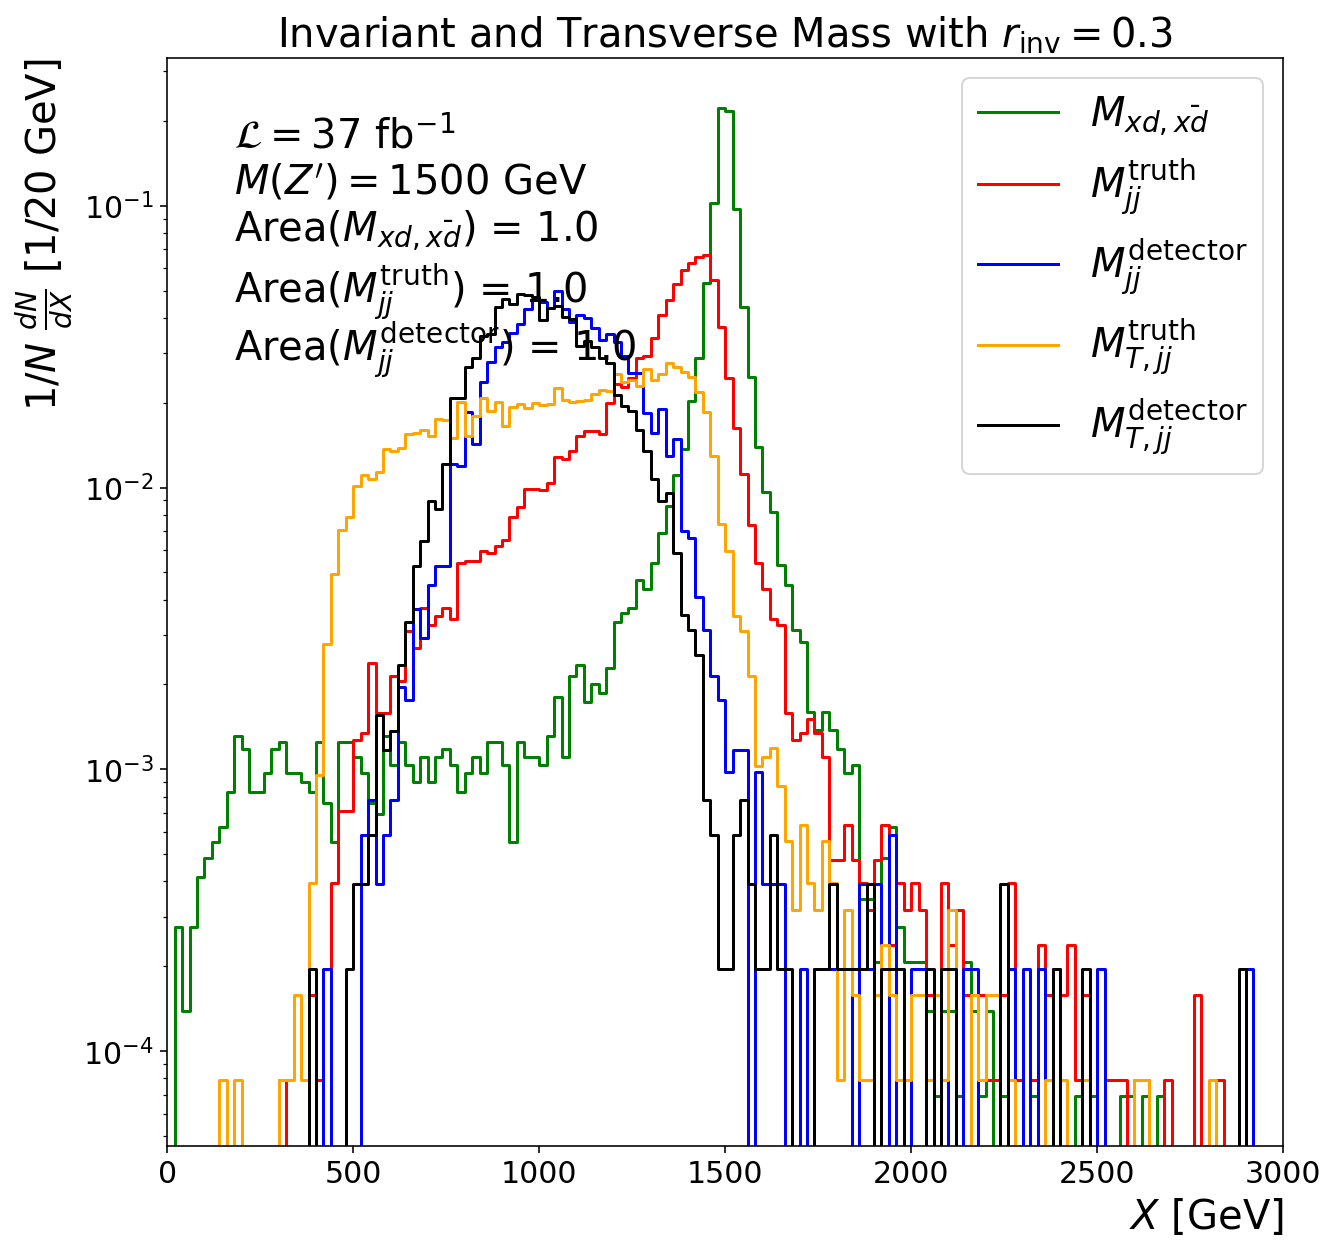

In [144]:
plt.figure(figsize=(10,10))  # plot size
print('Total events = {}'.format(len(m_xdxdbar_03_04)))

bin_size = np.linspace(0,5000,251)
hist, bins = np.histogram(m_xdxdbar_03_04, bins=bin_size, weights=weight_03_04)
plt.step(bins[:-1], hist/np.sum(hist), where='post', color='green', label='$M_{xd,\\bar{xd}}$')
# plt.step(bins[:-1], hist.astype(np.float32), where='post', color='green', label='$M_{xd,\\bar{xd}}$')

hist_M_JJ, bins_M_JJ = np.histogram(M_JJ_03_04, bins=bin_size, weights=weight_03_04[event_sele_03_04]*37*1000)
plt.step(bins_M_JJ[:-1], hist_M_JJ/np.sum(hist_M_JJ), where='post', color='red', label='$M^\mathrm{truth}_{jj}$')

hist_M_JJ_detec, bins_M_JJ_detec = np.histogram(dijet_mass_03_04, bins=bin_size, weights=weight_03_04[survived_list_03_04]*37*1000)
plt.step(bins_M_JJ_detec[:-1], hist_M_JJ_detec/np.sum(hist_M_JJ_detec), where='post', color='blue', label='$M^\mathrm{detector}_{jj}$')


hist_M_JJ, bins_M_JJ = np.histogram(MT_JJ_03_04, bins=bin_size, weights=weight_03_04[event_sele_03_04]*37*1000)
plt.step(bins_M_JJ[:-1], hist_M_JJ/np.sum(hist_M_JJ), where='post', color='orange', label='$M^\mathrm{truth}_{T,jj}$')

hist_M_JJ_detec, bins_M_JJ_detec = np.histogram(dijet_massT_03_04, bins=bin_size, weights=weight_03_04[survived_list_03_04]*37*1000)
plt.step(bins_M_JJ_detec[:-1], hist_M_JJ_detec/np.sum(hist_M_JJ_detec), where='post', color='black', label='$M^\mathrm{detector}_{T,jj}$')



plt.text(180, 0.16, '$\mathcal{L} = 37\ \mathrm{fb}^{-1}$', fontsize=20)
plt.text(180, 0.11, '$M(Z^\prime) = 1500$ GeV', fontsize=20)
plt.text(180, 0.075, 'Area($M_{xd,\\bar{xd}}$) = '+str(np.round(np.sum(hist.astype(np.float32)/np.sum(hist)),2)), fontsize=20)
plt.text(180, 0.045, 'Area($M^\mathrm{truth}_{jj}$) = '+str(np.round(np.sum(hist_M_JJ)/np.sum(hist_M_JJ),2)[0]), fontsize=20)
plt.text(180, 0.028, 'Area($M^\mathrm{detector}_{jj}$) = '+str(np.round(np.sum(hist_M_JJ_detec)/np.sum(hist_M_JJ_detec),2)[0]), fontsize=20)



plt.legend(fontsize=20)
plt.yscale('log')
plt.title('Invariant and Transverse Mass with $r_\mathrm{inv}=0.3$', fontsize=20)
plt.xlabel('$X$ [GeV]', fontsize=20, horizontalalignment='right', x=1)
plt.ylabel('$1/N\ \\frac{dN}{dX}$ [1/20 GeV]', fontsize=20, horizontalalignment='right', y=1)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim(0,3000)
# plt.ylim(0.001,0.1)
plt.show()

### 15-2. $M_{T,jj}^\text{truth}$

Total events = 17850
Total events = 14521
Total events = 17805
Total events = 14627


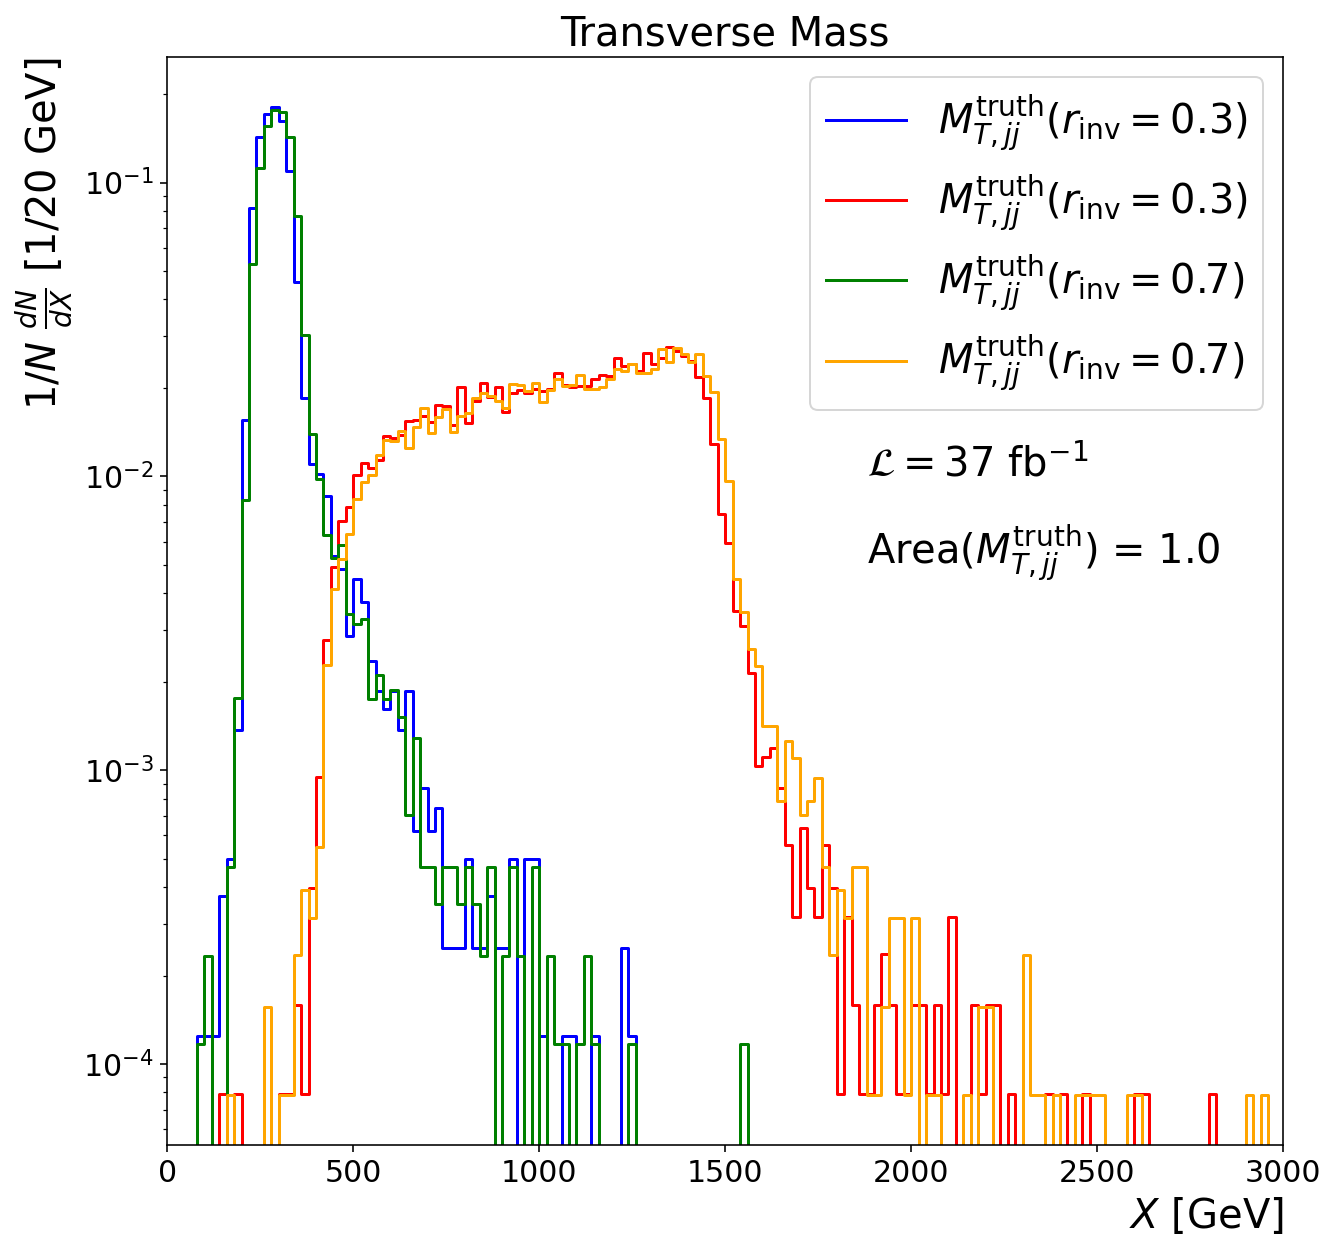

In [149]:
plt.figure(figsize=(10,10))  # plot size
print('Total events = {}'.format(len(m_xdxdbar_03_02)))
print('Total events = {}'.format(len(m_xdxdbar_03_04)))
print('Total events = {}'.format(len(m_xdxdbar_07_02)))
print('Total events = {}'.format(len(m_xdxdbar_07_04)))

bin_size = np.linspace(0,5000,251)
hist_M_JJ, bins_M_JJ = np.histogram(MT_JJ_03_02, bins=bin_size, weights=weight_03_02[event_sele_03_02]*37*1000)
plt.step(bins_M_JJ[:-1], hist_M_JJ/np.sum(hist_M_JJ), where='post', color='blue', label='$M^\mathrm{truth}_{T,jj}(r_\mathrm{inv}=0.3)$')

hist_M_JJ, bins_M_JJ = np.histogram(MT_JJ_03_04, bins=bin_size, weights=weight_03_04[event_sele_03_04]*37*1000)
plt.step(bins_M_JJ[:-1], hist_M_JJ/np.sum(hist_M_JJ), where='post', color='red', label='$M^\mathrm{truth}_{T,jj}(r_\mathrm{inv}=0.3)$')

hist_M_JJ, bins_M_JJ = np.histogram(MT_JJ_07_02, bins=bin_size, weights=weight_07_02[event_sele_07_02]*37*1000)
plt.step(bins_M_JJ[:-1], hist_M_JJ/np.sum(hist_M_JJ), where='post', color='green', label='$M^\mathrm{truth}_{T,jj}(r_\mathrm{inv}=0.7)$')

hist_M_JJ, bins_M_JJ = np.histogram(MT_JJ_07_04, bins=bin_size, weights=weight_07_04[event_sele_07_04]*37*1000)
plt.step(bins_M_JJ[:-1], hist_M_JJ/np.sum(hist_M_JJ), where='post', color='orange', label='$M^\mathrm{truth}_{T,jj}(r_\mathrm{inv}=0.7)$')



plt.text(1880, 0.01, '$\mathcal{L} = 37\ \mathrm{fb}^{-1}$', fontsize=20)
#plt.text(180, 0.11, '$M(Z^\prime) = 1500$ GeV', fontsize=20)
#plt.text(180, 0.075, 'Area($M_{xd,\\bar{xd}}$) = '+str(np.round(np.sum(hist.astype(np.float32)/np.sum(hist)),2)), fontsize=20)
plt.text(1880, 0.005, 'Area($M^\mathrm{truth}_{T,jj}$) = '+str(np.round(np.sum(hist_M_JJ)/np.sum(hist_M_JJ),2)[0]), fontsize=20)
#plt.text(180, 0.028, 'Area($M^\mathrm{detector}_{jj}$) = '+str(np.round(np.sum(hist_M_JJ_detec)/np.sum(hist_M_JJ_detec),2)[0]), fontsize=20)



plt.legend(fontsize=20)
plt.yscale('log')
plt.title('Transverse Mass', fontsize=20)
plt.xlabel('$X$ [GeV]', fontsize=20, horizontalalignment='right', x=1)
plt.ylabel('$1/N\ \\frac{dN}{dX}$ [1/20 GeV]', fontsize=20, horizontalalignment='right', y=1)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim(0,3000)
# plt.ylim(0.001,0.1)
plt.show()

## 16. $p_T$

In [154]:
PT1_03_02 = []
event_sele_03_02_PT1 = []

for i in range(len(event_jets_03_02)):
    if len(event_jets_03_02[i]) >= 2:  # at least two jets in this event.
        jet_1 = event_jets_03_02[i][0]  # leading jet's information
        jet_2 = event_jets_03_02[i][1]  # subleading jet's information
        
        PT1_03_02.append(jet_1.pt)
        event_sele_03_02_PT1.append(i)
        
print('There are {} events passed this di-jet selection.'.format(len(PT1_03_02)))

There are 8066 events passed this di-jet selection.


In [150]:
PT1_03_04 = []
event_sele_03_04_PT1 = []

for i in range(len(event_jets_03_04)):
    if len(event_jets_03_04[i]) >= 2:  # at least two jets in this event.
        jet_1 = event_jets_03_04[i][0]  # leading jet's information
        jet_2 = event_jets_03_04[i][1]  # subleading jet's information
        
        PT1_03_04.append(jet_1.pt)
        event_sele_03_04_PT1.append(i)
        
print('There are {} events passed this di-jet selection.'.format(len(PT1_03_04)))

There are 12683 events passed this di-jet selection.


In [155]:
PT1_07_02 = []
event_sele_07_02_PT1 = []

for i in range(len(event_jets_07_02)):
    if len(event_jets_07_02[i]) >= 2:  # at least two jets in this event.
        jet_1 = event_jets_07_02[i][0]  # leading jet's information
        jet_2 = event_jets_07_02[i][1]  # subleading jet's information
        
        PT1_07_02.append(jet_1.pt)
        event_sele_07_02_PT1.append(i)
        
print('There are {} events passed this di-jet selection.'.format(len(PT1_07_02)))

There are 8569 events passed this di-jet selection.


In [156]:
PT1_07_04 = []
event_sele_07_04_PT1 = []

for i in range(len(event_jets_07_04)):
    if len(event_jets_07_04[i]) >= 2:  # at least two jets in this event.
        jet_1 = event_jets_07_04[i][0]  # leading jet's information
        jet_2 = event_jets_07_04[i][1]  # subleading jet's information
        
        PT1_07_04.append(jet_1.pt)
        event_sele_07_04_PT1.append(i)
        
print('There are {} events passed this di-jet selection.'.format(len(PT1_07_04)))

There are 12837 events passed this di-jet selection.


### 16-1. $r_\mathrm{inv}=0.3$ and $M_{Z^\prime}=1500$ GeV

Total events = 14521


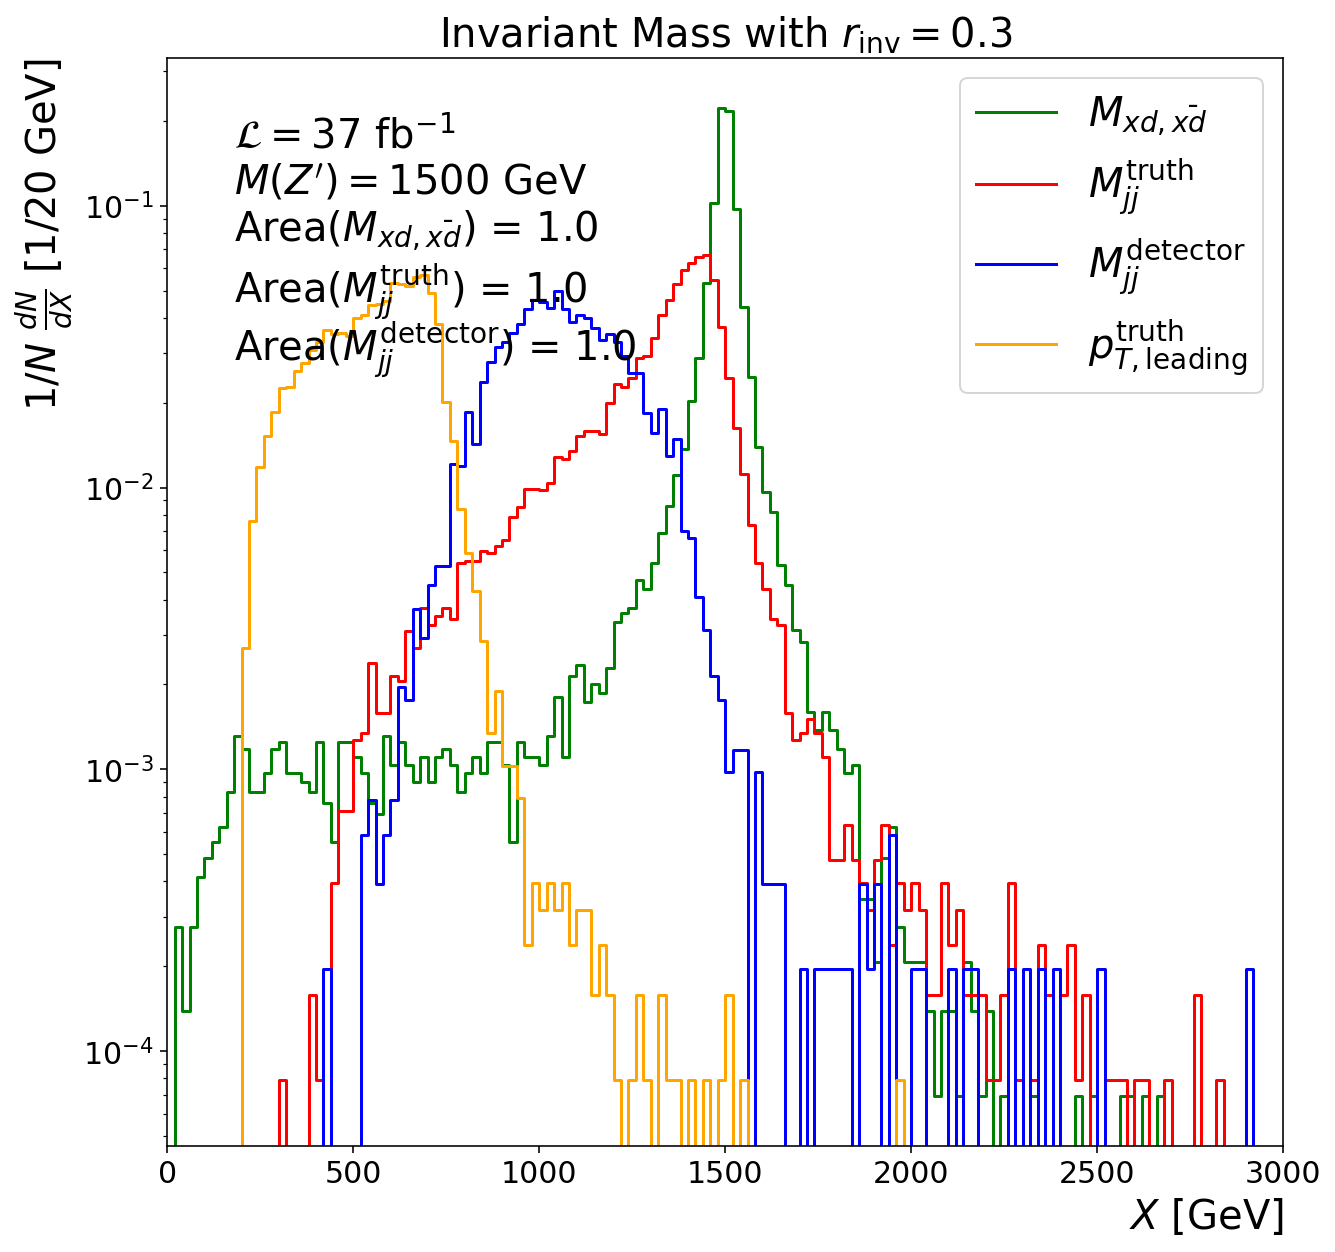

In [153]:
plt.figure(figsize=(10,10))  # plot size
print('Total events = {}'.format(len(m_xdxdbar_03_04)))

bin_size = np.linspace(0,5000,251)
hist, bins = np.histogram(m_xdxdbar_03_04, bins=bin_size, weights=weight_03_04)
plt.step(bins[:-1], hist/np.sum(hist), where='post', color='green', label='$M_{xd,\\bar{xd}}$')
# plt.step(bins[:-1], hist.astype(np.float32), where='post', color='green', label='$M_{xd,\\bar{xd}}$')

hist_M_JJ, bins_M_JJ = np.histogram(M_JJ_03_04, bins=bin_size, weights=weight_03_04[event_sele_03_04]*37*1000)
plt.step(bins_M_JJ[:-1], hist_M_JJ/np.sum(hist_M_JJ), where='post', color='red', label='$M^\mathrm{truth}_{jj}$')

hist_M_JJ_detec, bins_M_JJ_detec = np.histogram(dijet_mass_03_04, bins=bin_size, weights=weight_03_04[survived_list_03_04]*37*1000)
plt.step(bins_M_JJ_detec[:-1], hist_M_JJ_detec/np.sum(hist_M_JJ_detec), where='post', color='blue', label='$M^\mathrm{detector}_{jj}$')


hist_M_JJ, bins_M_JJ = np.histogram(PT1_03_04, bins=bin_size, weights=weight_03_04[event_sele_03_04]*37*1000)
plt.step(bins_M_JJ[:-1], hist_M_JJ/np.sum(hist_M_JJ), where='post', color='orange', label='$p^\mathrm{truth}_{T,\mathrm{leading}}$')


plt.text(180, 0.16, '$\mathcal{L} = 37\ \mathrm{fb}^{-1}$', fontsize=20)
plt.text(180, 0.11, '$M(Z^\prime) = 1500$ GeV', fontsize=20)
plt.text(180, 0.075, 'Area($M_{xd,\\bar{xd}}$) = '+str(np.round(np.sum(hist.astype(np.float32)/np.sum(hist)),2)), fontsize=20)
plt.text(180, 0.045, 'Area($M^\mathrm{truth}_{jj}$) = '+str(np.round(np.sum(hist_M_JJ)/np.sum(hist_M_JJ),2)[0]), fontsize=20)
plt.text(180, 0.028, 'Area($M^\mathrm{detector}_{jj}$) = '+str(np.round(np.sum(hist_M_JJ_detec)/np.sum(hist_M_JJ_detec),2)[0]), fontsize=20)



plt.legend(fontsize=20)
plt.yscale('log')
plt.title('Invariant Mass with $r_\mathrm{inv}=0.3$', fontsize=20)
plt.xlabel('$X$ [GeV]', fontsize=20, horizontalalignment='right', x=1)
plt.ylabel('$1/N\ \\frac{dN}{dX}$ [1/20 GeV]', fontsize=20, horizontalalignment='right', y=1)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim(0,3000)
# plt.ylim(0.001,0.1)
plt.show()

Total events = 8066
Total events = 12683
Total events = 8569
Total events = 12837


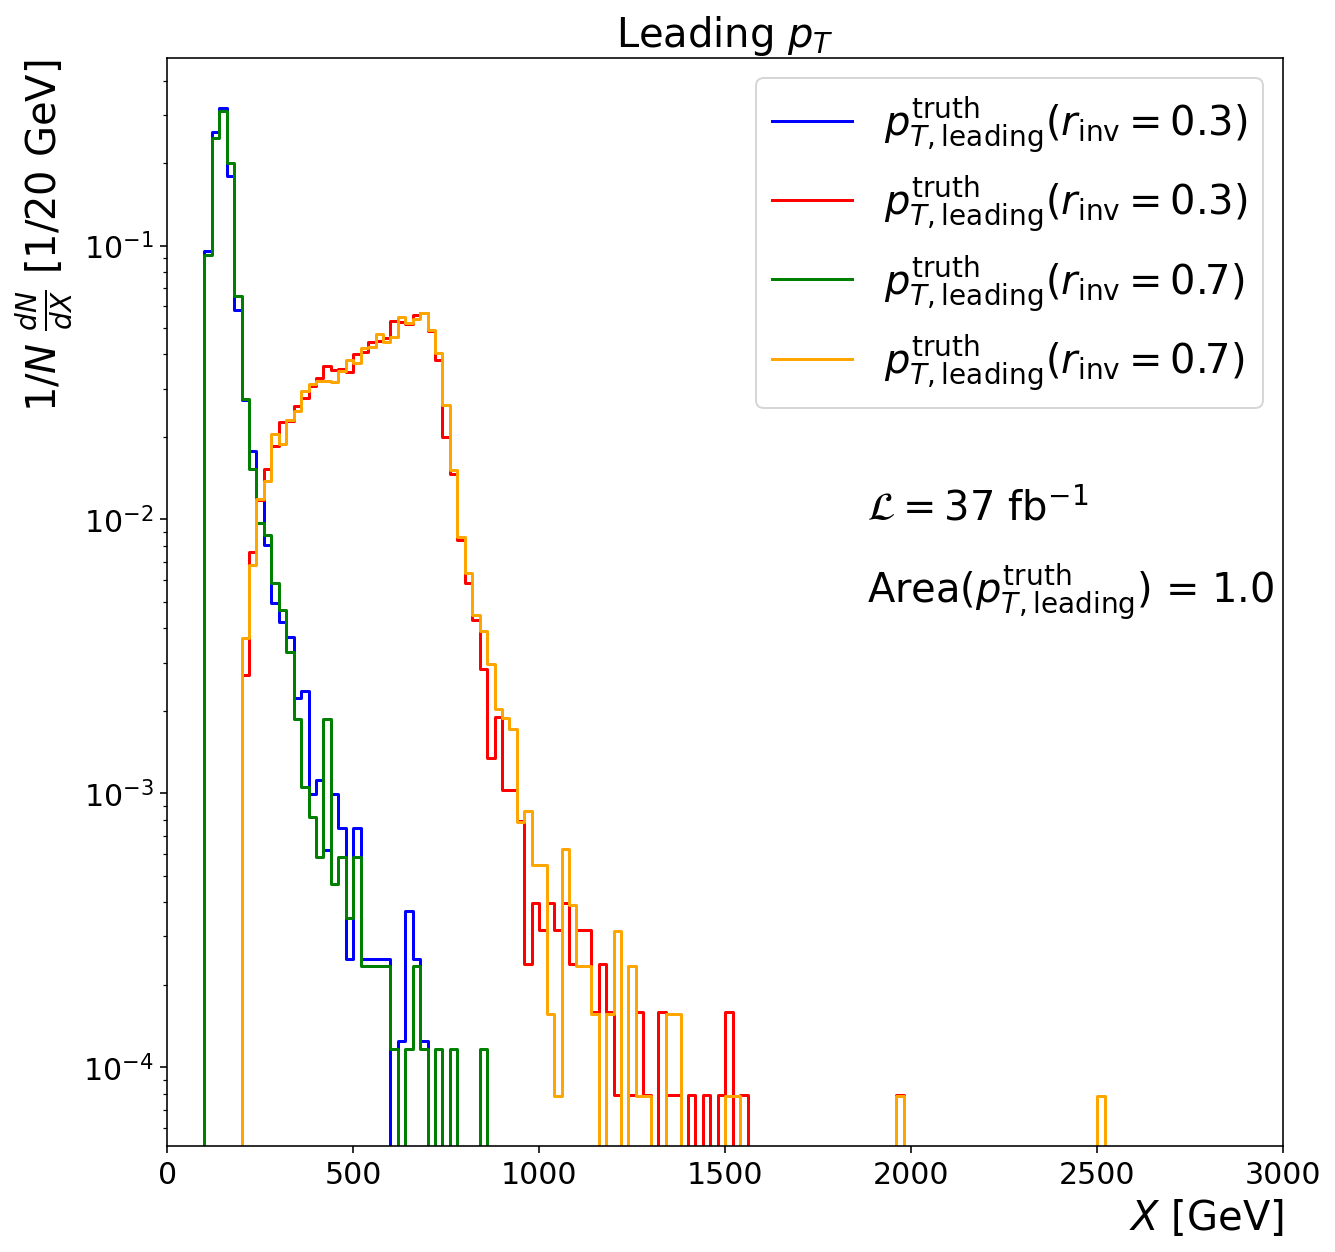

In [163]:
plt.figure(figsize=(10,10))  # plot size
print('Total events = {}'.format(len(PT1_03_02)))
print('Total events = {}'.format(len(PT1_03_04)))
print('Total events = {}'.format(len(PT1_07_02)))
print('Total events = {}'.format(len(PT1_07_04)))

bin_size = np.linspace(0,5000,251)
hist_M_JJ, bins_M_JJ = np.histogram(PT1_03_02, bins=bin_size, weights=weight_03_02[event_sele_03_02]*37*1000)
plt.step(bins_M_JJ[:-1], hist_M_JJ/np.sum(hist_M_JJ), where='post', color='blue', label='$p^\mathrm{truth}_{T,\mathrm{leading}}(r_\mathrm{inv}=0.3)$')

hist_M_JJ, bins_M_JJ = np.histogram(PT1_03_04, bins=bin_size, weights=weight_03_04[event_sele_03_04]*37*1000)
plt.step(bins_M_JJ[:-1], hist_M_JJ/np.sum(hist_M_JJ), where='post', color='red', label='$p^\mathrm{truth}_{T,\mathrm{leading}}(r_\mathrm{inv}=0.3)$')

hist_M_JJ, bins_M_JJ = np.histogram(PT1_07_02, bins=bin_size, weights=weight_07_02[event_sele_07_02]*37*1000)
plt.step(bins_M_JJ[:-1], hist_M_JJ/np.sum(hist_M_JJ), where='post', color='green', label='$p^\mathrm{truth}_{T,\mathrm{leading}}(r_\mathrm{inv}=0.7)$')

hist_M_JJ, bins_M_JJ = np.histogram(PT1_07_04, bins=bin_size, weights=weight_07_04[event_sele_07_04]*37*1000)
plt.step(bins_M_JJ[:-1], hist_M_JJ/np.sum(hist_M_JJ), where='post', color='orange', label='$p^\mathrm{truth}_{T,\mathrm{leading}}(r_\mathrm{inv}=0.7)$')



plt.text(1880, 0.01, '$\mathcal{L} = 37\ \mathrm{fb}^{-1}$', fontsize=20)
#plt.text(180, 0.11, '$M(Z^\prime) = 1500$ GeV', fontsize=20)
#plt.text(180, 0.075, 'Area($M_{xd,\\bar{xd}}$) = '+str(np.round(np.sum(hist.astype(np.float32)/np.sum(hist)),2)), fontsize=20)
plt.text(1880, 0.005, 'Area($p^\mathrm{truth}_{T,\mathrm{leading}}$) = '+str(np.round(np.sum(hist_M_JJ)/np.sum(hist_M_JJ),2)[0]), fontsize=20)
#plt.text(180, 0.028, 'Area($M^\mathrm{detector}_{jj}$) = '+str(np.round(np.sum(hist_M_JJ_detec)/np.sum(hist_M_JJ_detec),2)[0]), fontsize=20)



plt.legend(fontsize=20)
plt.yscale('log')
plt.title('Leading $p_T$', fontsize=20)
plt.xlabel('$X$ [GeV]', fontsize=20, horizontalalignment='right', x=1)
plt.ylabel('$1/N\ \\frac{dN}{dX}$ [1/20 GeV]', fontsize=20, horizontalalignment='right', y=1)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim(0,3000)
# plt.ylim(0.001,0.1)
plt.show()